### Import necessary libraries:

In [123]:
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,log_loss,roc_curve, roc_auc_score,cohen_kappa_score,f1_score,recall_score,precision_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

## Problem statement:

- The primary objective is to detect fraudulent transactions within the dataset accurately. This involves identifying transactions that are not legitimate and distinguishing them from legitimate ones.

- The dataset contains transaction data with 786,363 records and 29 features. It includes details such as account and customer identifiers, transaction amounts, merchant information, and indicators of fraudulent     transactions. The "isFraud" column indicates whether a transaction is fraudulent, with approximately 1.58% of transactions labeled as fraud. Missing data is observed in several columns, including "acqCountry," "posEntryMode" and "transactionType." Additionally, a subset of 12,417 records pertains to fraudulent transactions.

### Original dataset (Population)

In [14]:
# Data Reading Directory
directory = r'C:\\Gopi\\Study material\\GL\\Revision for final exam\\Capstone project\\Credit card default\\Report\\Final report\\Jupyter notebook\\transactions.txt'

# Reading text from text file
with open(directory) as txt_file:
    lines = txt_file.readlines()

# Text in text file was in JSON format
# Converting text lines to JSON format and then restructuring as a dataframe 
trxn_data = []
for line in lines:
    trxn_data.append(json.loads(line))

# Replacing blank fields with NaN values
df_pop = pd.DataFrame(trxn_data)
df_pop = df_pop.replace(r'', np.NaN)
df_pop.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [17]:
df_pop['isFraud'].value_counts()

isFraud
False    773946
True      12417
Name: count, dtype: int64

In [18]:
df_pop['isFraud'].value_counts(normalize=True) * 100 # Population target variable distribution                                  

isFraud
False    98.420958
True      1.579042
Name: proportion, dtype: float64

# Load the dataset:

In [20]:
df = pd.read_csv('stratified_transactions.csv')
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,302785707,302785707,15000.0,3165.82,2016-11-02T15:36:59,16.28,Dinosaur Sandwitch Bar #303701,US,US,5.0,...,NaN,11834.18,NaN,NaN,NaN,True,NaN,NaN,False,False
1,459769579,459769579,15000.0,13362.73,2016-09-24T04:56:14,5.32,Play Store,US,US,5.0,...,NaN,1637.27,NaN,NaN,NaN,False,NaN,NaN,False,False
2,668771382,668771382,5000.0,4786.28,2016-12-19T11:11:56,95.44,amazon.com,US,US,9.0,...,NaN,213.72,NaN,NaN,NaN,False,NaN,NaN,False,True
3,690307166,690307166,15000.0,8230.64,2016-11-29T04:22:19,154.17,Delta Airlines,US,US,5.0,...,NaN,6769.36,NaN,NaN,NaN,False,NaN,NaN,False,False
4,447442368,447442368,1000.0,644.36,2016-06-10T00:36:53,25.36,Sunoco Gas #931794,US,US,2.0,...,NaN,355.64,NaN,NaN,NaN,True,NaN,NaN,False,False


## Proof reading if sample is representative of population

In [21]:
df['isFraud'].value_counts(normalize=True) * 100 
# We can see that the distribution of the target variable is representative  of the distribution in the popultion dataset 

isFraud
False    98.421333
True      1.578667
Name: proportion, dtype: float64

In [22]:
df['isFraud'].value_counts()

isFraud
False    147632
True       2368
Name: count, dtype: int64

- The (sample) dataset contains transaction data with 150000 records and 29 features. It includes details such as account and customer identifiers, transaction amounts, merchant information, and indicators of fraudulent     transactions. The "isFraud" column indicates whether a transaction is fraudulent, with approximately 1.58% of transactions labeled as fraud. Missing data is observed in several columns, including "acqCountry," "posEntryMode" and "transactionType." Additionally, a subset of 2368 records pertains to fraudulent transactions.

## DATA dictionary:
- accountNumber             = The account number of The customer

- customerId    =  The ID of The customer

- creditLimit               =  The amount of money that can be charged to The debit card

- availableMoney        = The amount of money in The debit card before adjusting for pending charges      

- transactionDateTime       = The transaction timestamp when it happened
  
- transactionAmount        = The amount of transaction 

- merchantName          = The merchant name of The particular transaction

- acqCountry             = The country where The merchant is located

- merchantCountryCode    = The country code for The specific merchant

- posEntryMode        = a code that tells The processor how The transaction was captured

- posConditionCode   = a code identifying transaction conditions at The point-of-sale or point-of-service

- POS Entry Mode
        
        2 - PAN auto-entry via magnetic stripe
        
        5 - PAN auto-entry via chip
        
        9 -  PAN entry via electronic commerce, including remote chip
        
        80 - Chip card at chip-capable terminal was unable to process transactions using data on the chip–terminal defaulted to magnetic stripe-read PAN
        
        99- PAN auto entry via magnetic stripe-full track data has been read without alteration or truncation
        
- POS Condition Code
        
        1 (Sale): This code indicates that a sale transaction has been processed. The merchant must collect the customer's signature for this type of transaction.
        
        8 (Void): This code indicates that a previously processed sale transaction has been voided. The merchant must not collect the customer's signature for this type of transaction.
        
        99 (Refund): This code indicates that a previously processed sale transaction has been refunded. The merchant must collect the customer's signature for this type of transaction.	


- merchantCategoryCode    = The merchant category/types

- currentExpDate       =  The expiry date of The credit card

- accountOpenDate      = The date when The customer open The credit card

- dateOfLastAddressChange    = The last date when The customer change The credit card address

- cardCVV = The actual card verification value

- enteredCVV       = The entered card verification value

- cardLast4Digits     = The last 4 digits of The debit card

- transactionType        = The types of transactions

- isFraud      = The status of The fraud transaction

- echoBuffer    = number of delayed response transactions

- currentBalance =  The current balance of The debit card

- merchantCity = The location for The specific merchant (City)

- merchantState   = The location for The specific merchant (State)

- merchantZip = The location for The specific merchant (Zip Code)           

- cardPresent =     The physical presence of The debit card in The transaction

- posOnPremises = The location of The point of sales          

- recurringAuthInd  = wheTher The auThentication recurred or not

- expirationDateKeyInMatch = The match between The expiration date in The system and what was inputted

In [23]:
df.shape # Rows = 150000 & Columns = 29

(150000, 29)

In [24]:
df.columns # Name of the columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'echoBuffer', 'currentBalance', 'merchantCity',
       'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises',
       'recurringAuthInd', 'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')

- Data type check:

In [25]:
df.info() # Display non-null count & data type of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             150000 non-null  int64  
 1   customerId                150000 non-null  int64  
 2   creditLimit               150000 non-null  float64
 3   availableMoney            150000 non-null  float64
 4   transactionDateTime       150000 non-null  object 
 5   transactionAmount         150000 non-null  float64
 6   merchantName              150000 non-null  object 
 7   acqCountry                149109 non-null  object 
 8   merchantCountryCode       149850 non-null  object 
 9   posEntryMode              149228 non-null  float64
 10  posConditionCode          149907 non-null  float64
 11  merchantCategoryCode      150000 non-null  object 
 12  currentExpDate            150000 non-null  object 
 13  accountOpenDate           150000 non-null  o

In [27]:
for col in df.columns: # Check the subclasses within each column
    print(df[col].value_counts(),end='\n\n')

accountNumber
380680241    6179
882815134    2496
570884863    2071
246251253    1911
369308035    1365
             ... 
518348385       1
397486395       1
675800660       1
675372340       1
997884003       1
Name: count, Length: 4774, dtype: int64

customerId
380680241    6179
882815134    2496
570884863    2071
246251253    1911
369308035    1365
             ... 
518348385       1
397486395       1
675800660       1
675372340       1
997884003       1
Name: count, Length: 4774, dtype: int64

creditLimit
5000.0     38560
15000.0    26574
7500.0     18681
2500.0     14392
20000.0    13086
10000.0    10850
50000.0     9261
1000.0      7035
250.0       6517
500.0       5044
Name: count, dtype: int64

availableMoney
250.00      1162
5000.00      988
15000.00     835
7500.00      789
500.00       563
            ... 
2257.82        1
14037.67       1
547.53         1
4724.96        1
5197.59        1
Name: count, Length: 131893, dtype: int64

transactionDateTime
2016-06-27T21:24:03    

'accountNumber' & 'customerId' seem to be duplicate columns both representing customer information.

**Handling mismatched datatypes:**

In [28]:
df['posEntryMode'] = df['posEntryMode'].astype('O') # Categorical variable
df['posConditionCode'] = df['posConditionCode'].astype('O') # Categorical variable

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             150000 non-null  int64  
 1   customerId                150000 non-null  int64  
 2   creditLimit               150000 non-null  float64
 3   availableMoney            150000 non-null  float64
 4   transactionDateTime       150000 non-null  object 
 5   transactionAmount         150000 non-null  float64
 6   merchantName              150000 non-null  object 
 7   acqCountry                149109 non-null  object 
 8   merchantCountryCode       149850 non-null  object 
 9   posEntryMode              149228 non-null  object 
 10  posConditionCode          149907 non-null  object 
 11  merchantCategoryCode      150000 non-null  object 
 12  currentExpDate            150000 non-null  object 
 13  accountOpenDate           150000 non-null  o

<u>Inference:</u>
- We can see six columns with 100% null values

### <u>Statistical summary</u> (of numeric values):

In [30]:
df.describe(include=np.number) # 5 point summary of Numeric columns

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,posOnPremises,recurringAuthInd
count,1.500000e+05,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,0.0,150000.000000,0.0,0.0,0.0,0.0,0.0
mean,5.364365e+08,5.364365e+08,10746.358333,6242.929408,136.549893,543.943793,543.653053,4760.102193,NaN,4503.428925,NaN,NaN,NaN,NaN,NaN
std,2.555833e+08,2.555833e+08,11616.658124,8854.027279,147.557561,261.755507,261.752797,2999.745700,NaN,6448.742213,NaN,NaN,NaN,NaN,NaN
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,3.288624e+08,3.288624e+08,5000.000000,1081.472500,33.350000,308.000000,308.000000,2178.000000,NaN,690.967500,NaN,NaN,NaN,NaN,NaN
50%,5.046004e+08,5.046004e+08,7500.000000,3194.370000,87.575000,535.000000,535.000000,4740.000000,NaN,2447.805000,NaN,NaN,NaN,NaN,NaN
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,190.960000,785.000000,784.000000,7349.000000,NaN,5272.257500,NaN,NaN,NaN,NaN,NaN
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,1608.350000,998.000000,998.000000,9998.000000,NaN,47498.810000,NaN,NaN,NaN,NaN,NaN


<b>Inference:</b>
<ul> <li>'creditLimit' (maximum amount of money customer can spend using the credit card):</ul> </li>Average = 10746.3, Minimum = 250, 50% = 7500, Maximum = 50000 (presence of outliers on higher scale & positive skewness)
<ul> <li>'availableMoney' (remaining amount of money before penalty is applied):</ul> </li>Average = 6242.9, Minimum = -1005.6, 50% = 3194.3, Maximum = 50000 (presence of outliers on higher scale & positive skewness)
<ul> <li>'transactionAmount' (the amount of transaction):</ul> </li>Average = 136.5, Minimum = 0, 50% = 87.5, Maximum = 1608.3 (presence of outliers on higher scale & positive skewness)
<ul> <li>'currentBalance'(current balance of The debit card):</ul> </li>Average = 4503.4, Minimum = 0, 50% = 2447.8, Maximum = 47498.8 (presence of outliers & positive skewness)
<ul> <li>'echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd' - 100% null values in these columns.

### <u>Summary</u> (of categorical values):

In [12]:
df.describe(exclude=np.number)

,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,transactionType,cardPresent,expirationDateKeyInMatch,isFraud
count,150000,150000,149109,149850,149228.0,149907.0,150000,150000,150000,150000,149877,150000,150000,150000
unique,149639,2464,4,4,5.0,3.0,19,165,1789,2139,3,2,2,2
top,2016-06-27T21:24:03,Lyft,US,US,5.0,1.0,online_retail,08/2024,2014-06-21,2016-03-15,PURCHASE,False,False,False
freq,2,4942,147783,148517,60295.0,119964.0,38471,1013,6310,717,142015,82822,149788,147632


<b>Inference:</b>
<ul> <li>'transactionDateTime'</ul></li> Most of the transaction happened during June Month end on 2016.
<ul> <li>'merchantName' (merchant name of the particular transaction):</ul> </li> There are 2464 unique Merchants & most of the transactions(4942) happened in merchant 'Lyft'.
<ul> <li>'acqCountry' (country where the merchant is located):</ul> </li> There are 4 unique countries & most of the transactions(147783) happened from merchants in 'US'.
<ul> <li>'merchantCountryCode' (country code for The specific merchant):</ul> </li>There are 4 unique 'merchantCountryCode' & most of the transactions(148517) happened from merchants in 'US'.
<ul> <li>'posEntryMode' (auto-entry via chip):</ul> </li> There are 5 unique 'posEntryMode', most of the transactions(60295) happened in PAN auto-entry via chip(5).
<ul> <li>'posConditionCode' :</ul> </li>There are 3 unique 'posConditionCode', most of the transactions(119964) in which sale transaction has been processed(1).
<ul> <li>'currentExpDate'</ul> </li>Most of the customer's credit card expires on August 2024.
<ul> <li>'accountOpenDate'</ul> </li>Most of the customer's have opened their account on June month end 2014.
<ul> <li>'dateOfLastAddressChange'</ul></li>Most of the customer's have opened their account on March middel of the month in 2016.
<ul> <li>'merchantCategoryCode' (merchant category/types):</ul> </li>There are 19 unique 'merchantCategoryCode', most of the transactions(38471) customers paid to merchant who belonged to 'online_retail'.
<ul> <li>'transactionType' :</ul> </li> The are 3 unique  entries in 'transactionType', most of the transactions(142015) belonged to category 'PURCHASE'.
<ul> <li>'cardPresent' (physical presence of the debit card in The transaction):</ul> </li> There are 2 two unique entries(Card present - 'True' & Card not present - 'False'), most of the transactions(82822) indicated the card was not physically present(False).  
<ul> <li>'expirationDateKeyInMatch' (match between The expiration date in the system and what was inputted):</ul></li>Most of the transactions (149788) indicated there wasn't a match in the actual card expiry date and card expiry date customer entered in the transaction(False).  
<ul> <li>'isFraud':</ul> </li>Most of the transactions (147632) indicated they were biased towards non-fradulant. Whereas only 2368 were fraudulent. Indicating high imbalance in target variable.

### Null values:

- Null value detection:

In [31]:
(df.isnull().sum() / len(df)) * 100 # % of null values in each column

accountNumber                 0.000000
customerId                    0.000000
creditLimit                   0.000000
availableMoney                0.000000
transactionDateTime           0.000000
transactionAmount             0.000000
merchantName                  0.000000
acqCountry                    0.594000
merchantCountryCode           0.100000
posEntryMode                  0.514667
posConditionCode              0.062000
merchantCategoryCode          0.000000
currentExpDate                0.000000
accountOpenDate               0.000000
dateOfLastAddressChange       0.000000
cardCVV                       0.000000
enteredCVV                    0.000000
cardLast4Digits               0.000000
transactionType               0.082000
echoBuffer                  100.000000
currentBalance                0.000000
merchantCity                100.000000
merchantState               100.000000
merchantZip                 100.000000
cardPresent                   0.000000
posOnPremises            

Inference:
   - 100% null values in 'echoBuffer' ,'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'. Hence we can drop these columns.
   - Lets drop 'accountNumber' & 'customerId' as they are just unique identifiers assigned to a customer and we can't infer anything from it
   - Lets drop the date related columns('transactionDateTime','currentExpDate','accountOpenDate',
                 'dateOfLastAddressChange','cardLast4Digits') as they don't seem to aid in our model building

In [32]:
df.shape # 29 columns before drop

(150000, 29)

In [33]:
df.drop(columns=['echoBuffer' ,'merchantCity', 'merchantState', 'merchantZip', 
                 'posOnPremises', 'recurringAuthInd','accountNumber','customerId',
                'transactionDateTime','currentExpDate','accountOpenDate',
                 'dateOfLastAddressChange','cardLast4Digits'],inplace=True)
df.shape # 16 columns after drop

(150000, 16)

- Null value imputation:

In [34]:
(df.isnull().sum() / len(df)) * 100 # % of null values in each column

creditLimit                 0.000000
availableMoney              0.000000
transactionAmount           0.000000
merchantName                0.000000
acqCountry                  0.594000
merchantCountryCode         0.100000
posEntryMode                0.514667
posConditionCode            0.062000
merchantCategoryCode        0.000000
cardCVV                     0.000000
enteredCVV                  0.000000
transactionType             0.082000
currentBalance              0.000000
cardPresent                 0.000000
expirationDateKeyInMatch    0.000000
isFraud                     0.000000
dtype: float64

In [35]:
for col in ['acqCountry','merchantCountryCode','posEntryMode','posConditionCode','transactionType']:
    print(df[col].value_counts()) # We can see high imbalance in subclasses in all the missing value columns

acqCountry
US     147783
MEX       600
CAN       441
PR        285
Name: count, dtype: int64
merchantCountryCode
US     148517
MEX       604
CAN       442
PR        287
Name: count, dtype: int64
posEntryMode
5.0     60295
9.0     45122
2.0     37158
90.0     3745
80.0     2908
Name: count, dtype: int64
posConditionCode
1.0     119964
8.0      28540
99.0      1403
Name: count, dtype: int64
transactionType
PURCHASE                142015
ADDRESS_VERIFICATION      3951
REVERSAL                  3911
Name: count, dtype: int64


Hence going for mode imputation will futher add to the high imbalance within the subclasses.
Hence to avoid this situation we go for 'backward' or 'forwardfill' missing value imputation.

- 'acqCountry'

In [36]:
df['acqCountry'].fillna(method='bfill').value_counts() # chosen approach

acqCountry
US     148667
MEX       600
CAN       443
PR        290
Name: count, dtype: int64

In [37]:
df['acqCountry'].fillna(method='ffill').value_counts()

acqCountry
US     148673
MEX       600
CAN       442
PR        285
Name: count, dtype: int64

In [38]:
df['acqCountry'].fillna(method='bfill',inplace=True)

- 'merchantCountryCode'

In [39]:
df['merchantCountryCode'].fillna(method='bfill').value_counts() # chosen approach

merchantCountryCode
US     148666
MEX       604
CAN       442
PR        288
Name: count, dtype: int64

In [40]:
df['merchantCountryCode'].fillna(method='ffill').value_counts()

merchantCountryCode
US     148667
MEX       604
CAN       442
PR        287
Name: count, dtype: int64

In [41]:
df['merchantCountryCode'].fillna(method='bfill',inplace=True)

- 'posEntryMode'

In [42]:
df['posEntryMode'].fillna(method='bfill').value_counts() 

posEntryMode
5.0     60617
9.0     45335
2.0     37367
90.0     3763
80.0     2918
Name: count, dtype: int64

In [43]:
df['posEntryMode'].fillna(method='ffill').value_counts() # chosen approach

posEntryMode
5.0     60629
9.0     45330
2.0     37363
90.0     3762
80.0     2916
Name: count, dtype: int64

In [44]:
df['posEntryMode'].fillna(method='ffill',inplace=True)

- 'posConditionCode'

In [45]:
df['posConditionCode'].fillna(method='bfill').value_counts() 

posConditionCode
1.0     120034
8.0      28561
99.0      1405
Name: count, dtype: int64

In [46]:
df['posConditionCode'].fillna(method='ffill').value_counts()  # chosen approach

posConditionCode
1.0     120044
8.0      28553
99.0      1403
Name: count, dtype: int64

In [47]:
df['posConditionCode'].fillna(method='ffill',inplace=True)

- 'transactionType'

In [48]:
df['transactionType'].fillna(method='ffill').value_counts() # chosen approach

transactionType
PURCHASE                142132
ADDRESS_VERIFICATION      3956
REVERSAL                  3912
Name: count, dtype: int64

In [49]:
df['transactionType'].fillna(method='bfill').value_counts()

transactionType
PURCHASE                142134
ADDRESS_VERIFICATION      3953
REVERSAL                  3913
Name: count, dtype: int64

In [50]:
df['transactionType'].fillna(method='ffill',inplace=True)

All null values have been handled

In [51]:
(df.isnull().sum() / len(df)) * 100 

creditLimit                 0.0
availableMoney              0.0
transactionAmount           0.0
merchantName                0.0
acqCountry                  0.0
merchantCountryCode         0.0
posEntryMode                0.0
posConditionCode            0.0
merchantCategoryCode        0.0
cardCVV                     0.0
enteredCVV                  0.0
transactionType             0.0
currentBalance              0.0
cardPresent                 0.0
expirationDateKeyInMatch    0.0
isFraud                     0.0
dtype: float64

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   creditLimit               150000 non-null  float64
 1   availableMoney            150000 non-null  float64
 2   transactionAmount         150000 non-null  float64
 3   merchantName              150000 non-null  object 
 4   acqCountry                150000 non-null  object 
 5   merchantCountryCode       150000 non-null  object 
 6   posEntryMode              150000 non-null  float64
 7   posConditionCode          150000 non-null  float64
 8   merchantCategoryCode      150000 non-null  object 
 9   cardCVV                   150000 non-null  int64  
 10  enteredCVV                150000 non-null  int64  
 11  transactionType           150000 non-null  object 
 12  currentBalance            150000 non-null  float64
 13  cardPresent               150000 non-null  b

In [53]:
df['posEntryMode'] = df['posEntryMode'].astype('O') # Categorical variable
df['posConditionCode'] = df['posConditionCode'].astype('O') # Categorical variable
df['isFraud'] = df['isFraud'].astype('O') # Categorical variable

df['cardCVV'] = df['cardCVV'].astype('O') # we will later feature engineer a column 'CVV_Match' from these two columns
df['enteredCVV'] = df['enteredCVV'].astype('O')

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   creditLimit               150000 non-null  float64
 1   availableMoney            150000 non-null  float64
 2   transactionAmount         150000 non-null  float64
 3   merchantName              150000 non-null  object 
 4   acqCountry                150000 non-null  object 
 5   merchantCountryCode       150000 non-null  object 
 6   posEntryMode              150000 non-null  object 
 7   posConditionCode          150000 non-null  object 
 8   merchantCategoryCode      150000 non-null  object 
 9   cardCVV                   150000 non-null  object 
 10  enteredCVV                150000 non-null  object 
 11  transactionType           150000 non-null  object 
 12  currentBalance            150000 non-null  float64
 13  cardPresent               150000 non-null  b

#### Duplicate rows:

In [55]:
df[df.duplicated()] # There are 388 duplicate columns

,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardCVV,enteredCVV,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
1591,15000.0,14990.24,7.20,Apple iTunes,US,US,5.0,1.0,mobileapps,828,828,PURCHASE,9.76,False,False,False
5948,5000.0,4970.58,36.19,Runners #293826,US,US,9.0,1.0,gym,195,195,PURCHASE,29.42,False,False,False
6109,1000.0,1000.00,21.50,abc.com,US,US,5.0,1.0,online_subscriptions,613,613,PURCHASE,0.00,False,False,False
9017,2500.0,2500.00,6.25,Apple iTunes,US,US,9.0,1.0,mobileapps,543,543,PURCHASE,0.00,False,False,False
11627,2500.0,2412.04,29.32,MyApron,US,US,9.0,1.0,food_delivery,956,956,PURCHASE,87.96,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149383,15000.0,15000.00,8.29,Play Store,US,US,9.0,1.0,mobileapps,533,533,PURCHASE,0.00,False,False,False
149713,7500.0,7500.00,6.95,Play Store,US,US,2.0,1.0,mobileapps,330,330,PURCHASE,0.00,False,False,False
149755,15000.0,15000.00,4.44,Apple iTunes,US,US,5.0,1.0,mobileapps,374,374,PURCHASE,0.00,False,False,False
149973,20000.0,20000.00,6.72,Apple iTunes,US,US,5.0,1.0,mobileapps,464,464,PURCHASE,0.00,False,False,False


In [56]:
df.drop_duplicates(inplace=True,ignore_index=True)

In [57]:
df.shape

(149612, 16)

In [58]:
df['isFraud'].value_counts(normalize=True) * 100 # we can see the distribution of the target variable is still maintained

isFraud
False    98.417239
True      1.582761
Name: proportion, dtype: float64

- Numerical variables:

In [59]:
df_num = df.select_dtypes(include=np.number)
df_num

,creditLimit,availableMoney,transactionAmount,currentBalance
0,15000.0,3165.82,16.28,11834.18
1,15000.0,13362.73,5.32,1637.27
2,5000.0,4786.28,95.44,213.72
3,15000.0,8230.64,154.17,6769.36
4,1000.0,644.36,25.36,355.64
...,...,...,...,...
149607,2500.0,2288.18,196.84,211.82
149608,5000.0,3221.61,5.19,1778.39
149609,500.0,200.20,365.13,299.80
149610,15000.0,4641.56,198.40,10358.44


- Categorical variables:

In [60]:
df.select_dtypes(exclude=np.number)

,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,cardCVV,enteredCVV,transactionType,cardPresent,expirationDateKeyInMatch,isFraud
0,Dinosaur Sandwitch Bar #303701,US,US,5.0,1.0,food,742,742,PURCHASE,True,False,False
1,Play Store,US,US,5.0,8.0,mobileapps,440,440,PURCHASE,False,False,False
2,amazon.com,US,US,9.0,1.0,online_retail,699,699,PURCHASE,False,False,True
3,Delta Airlines,US,US,5.0,8.0,airline,612,612,PURCHASE,False,False,False
4,Sunoco Gas #931794,US,US,2.0,1.0,fuel,927,927,PURCHASE,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
149607,Rodeway Inn #105130,US,US,5.0,1.0,hotels,888,888,PURCHASE,False,False,False
149608,walmart.com,US,US,9.0,1.0,online_retail,713,716,PURCHASE,False,False,False
149609,1st Restaurant,US,US,5.0,1.0,food,909,909,PURCHASE,True,False,False
149610,WSC #998991,US,US,5.0,1.0,health,689,689,PURCHASE,False,False,False


In [61]:
df_cat = df[['merchantName','acqCountry','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode','transactionType','cardPresent','expirationDateKeyInMatch','isFraud']]
df_cat 

,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,isFraud
0,Dinosaur Sandwitch Bar #303701,US,US,5.0,1.0,food,PURCHASE,True,False,False
1,Play Store,US,US,5.0,8.0,mobileapps,PURCHASE,False,False,False
2,amazon.com,US,US,9.0,1.0,online_retail,PURCHASE,False,False,True
3,Delta Airlines,US,US,5.0,8.0,airline,PURCHASE,False,False,False
4,Sunoco Gas #931794,US,US,2.0,1.0,fuel,PURCHASE,True,False,False
...,...,...,...,...,...,...,...,...,...,...
149607,Rodeway Inn #105130,US,US,5.0,1.0,hotels,PURCHASE,False,False,False
149608,walmart.com,US,US,9.0,1.0,online_retail,PURCHASE,False,False,False
149609,1st Restaurant,US,US,5.0,1.0,food,PURCHASE,True,False,False
149610,WSC #998991,US,US,5.0,1.0,health,PURCHASE,False,False,False


# Exploratory Data Analysis:

### UNIVARIATE ANALYSIS:

- Numeric variables:

<u>Boxplot</u>:

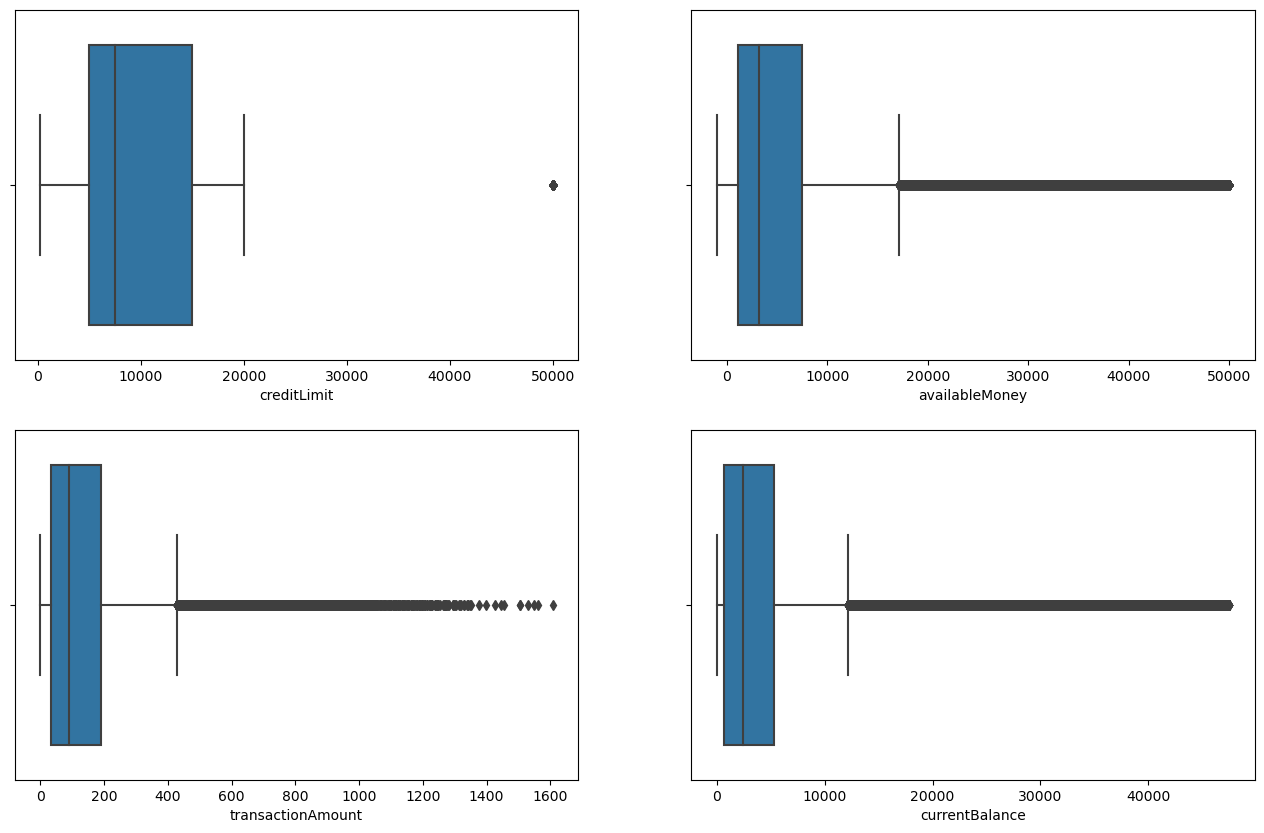

In [62]:
fig,ax = plt.subplots(2,2,figsize=(16,10))

for col,subplot in zip(df_num.columns,ax.flatten()):
    sns.boxplot(x=col,data=df,ax=subplot)
plt.show()

<u>Histogram</u>:

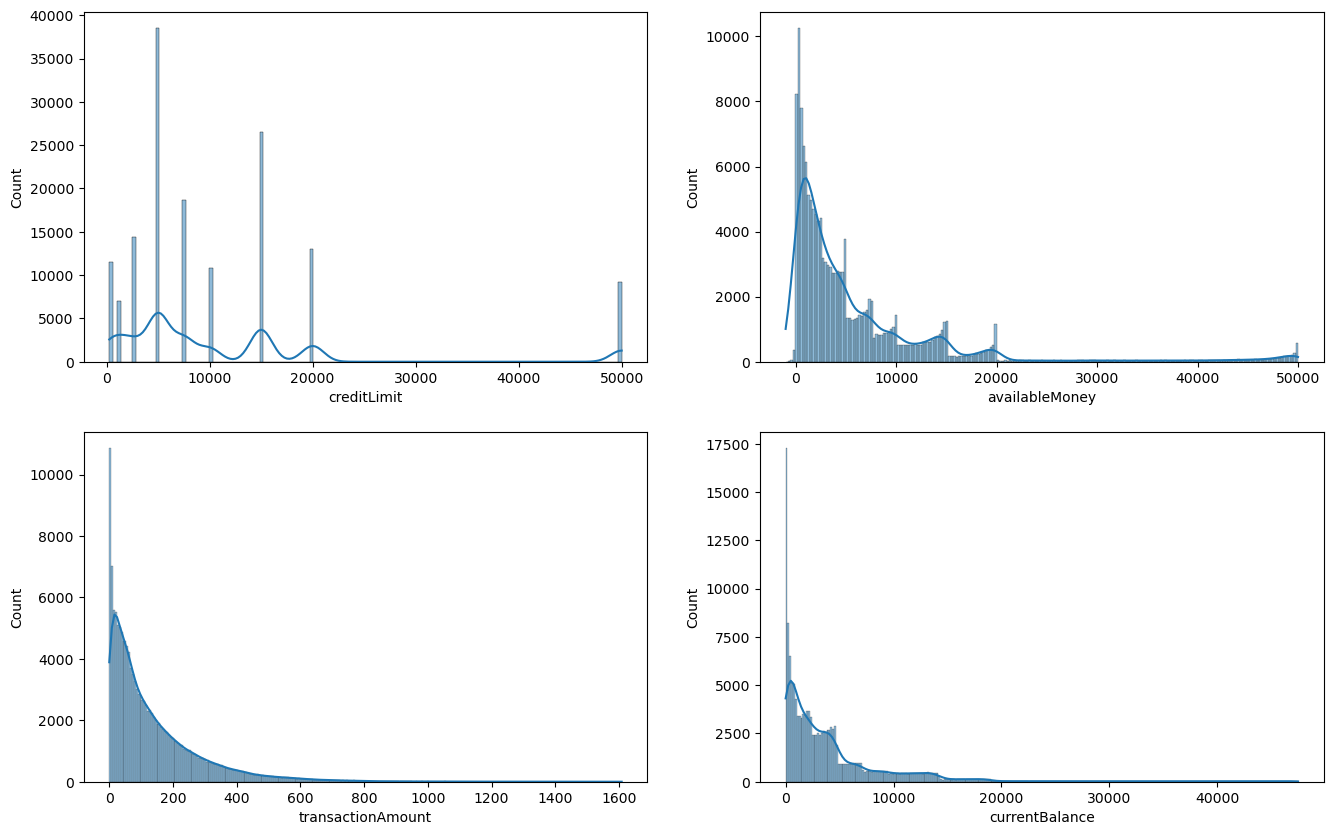

In [63]:
fig,ax = plt.subplots(2,2,figsize=(16,10))

for col,subplot in zip(df_num.columns,ax.flatten()):
    sns.histplot(x=col,data=df,kde=True,ax=subplot)
plt.show()

<b><u>Inference</u>:<b>
 - Highly skewed(mean>median>mode) data in the numeric variables indicating presence of outliers in the higher scale in all numeric variables.
 
'creditLimit' :
- High positive skewness(2.2) indicating presence of outliers in higher scale.
- 50% of the 'credit limit' values lie between 5000 and 15000.
- We can see outlier value of 50000

‘availableMoney’ :
- High positive skewness(3) indicating presence of outliers in higher scale & we can see huge no. of outliers.
- 50% of the 'avaiableMoney' values  lie between 1079 and 7500.
- We can see outlier value of 50000 (we have also seen the outlier value in ‘creditLimit’ as well)

‘transactionAmount’ :
- High positive skewness(2.11) indicating presence of outliers in higher scale & we can see huge no. of outliers.
- 50% of the 'transactionAmount' values lie between 33.6 and 191.4 indicating most of the transactions are of low value
- We can most outliers lie around 450 to 1300
- We can see extreme outlier value of 1608.3

'currentBalance' :
- High positive skewness(3.3) indicating presence of outliers in higher scale & we can see huge no. of outliers
- 50% of the ‘currentBalance’ values lie between 700.3 and 5291
- Most of the high credit limit customers have not spend most of the money from their credit card.
- We can see an extreme outlier value of 47498.8

<b>Categorical variables: </b>

In [67]:
df_cat.columns

Index(['merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode',
       'posConditionCode', 'merchantCategoryCode', 'transactionType',
       'cardPresent', 'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')

<u>Countplot</u>:

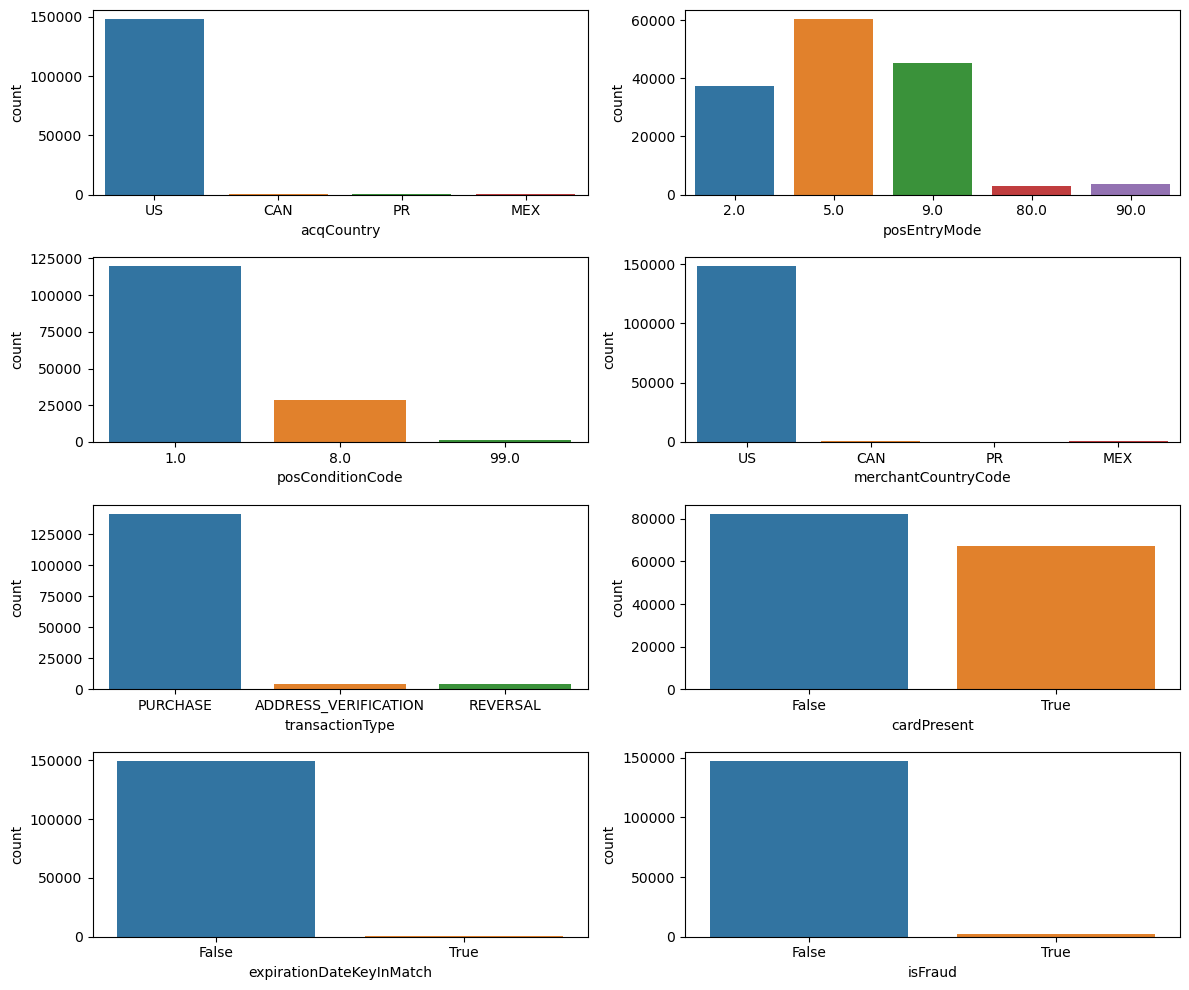

In [68]:
fig,ax = plt.subplots(4,2,figsize=(12,10))

for col,subplot in zip(['acqCountry','posEntryMode','posConditionCode','merchantCountryCode','transactionType','cardPresent','expirationDateKeyInMatch','isFraud'],ax.flatten()):
    sns.countplot(x=col,data=df,ax=subplot)
plt.tight_layout()
plt.show()

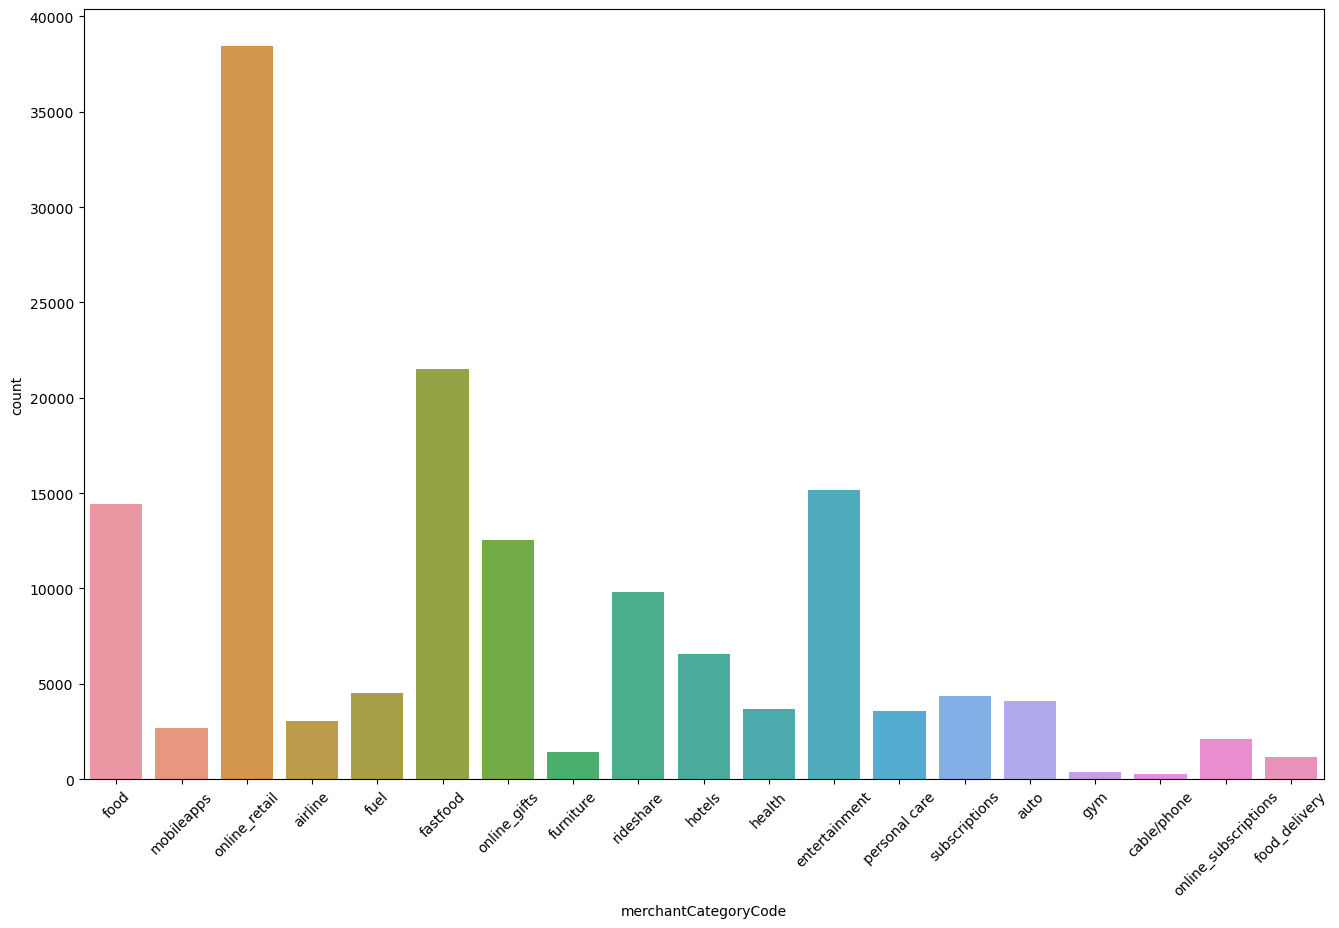

In [69]:
plt.figure(figsize=(16,10))
sns.countplot(x='merchantCategoryCode',data=df)
plt.xticks(rotation=45)
plt.show()

In [70]:
df['merchantName'].value_counts() # there are 2473 unique value, it won't be possible to visualize all of them

merchantName
Lyft                   4942
Uber                   4852
oldnavy.com            3309
gap.com                3256
alibaba.com            3253
                       ... 
EZ Wireless #561502       1
EZ Wireless #149871       1
Fast Mobile #554159       1
EZ Wireless #960630       1
Golds Gym #956354         1
Name: count, Length: 2464, dtype: int64

In [71]:
df['merchantName'].value_counts()[:20] # top twenty merchant names

merchantName
Lyft                        4942
Uber                        4852
oldnavy.com                 3309
gap.com                     3256
alibaba.com                 3253
walmart.com                 3233
amazon.com                  3222
staples.com                 3208
discount.com                3191
target.com                  3176
ebay.com                    3170
apple.com                   3169
cheapfast.com               3157
sears.com                   3124
Blue Mountain eCards        1615
Next Day Online Services    1610
Fresh eCards                1580
Fresh Online Services       1574
Mobile eCards               1547
Fresh Flowers               1544
Name: count, dtype: int64

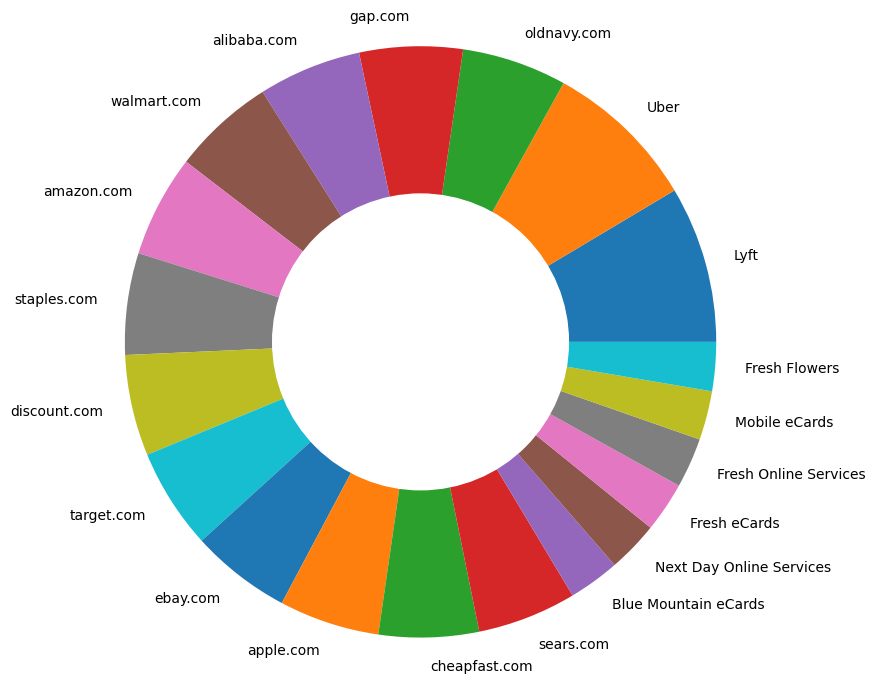

In [72]:
plt.pie(x=df['merchantName'].value_counts()[:20],data=df,radius=2,labels=df['merchantName'].value_counts()[:20].index) # lets visualize the top 20 merchants
circle = plt.Circle((0,0),radius=1,color='white')
plot = plt.gcf()
plt.gca().add_artist(circle)
plt.show()

In [73]:
df_cat

,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,isFraud
0,Dinosaur Sandwitch Bar #303701,US,US,5.0,1.0,food,PURCHASE,True,False,False
1,Play Store,US,US,5.0,8.0,mobileapps,PURCHASE,False,False,False
2,amazon.com,US,US,9.0,1.0,online_retail,PURCHASE,False,False,True
3,Delta Airlines,US,US,5.0,8.0,airline,PURCHASE,False,False,False
4,Sunoco Gas #931794,US,US,2.0,1.0,fuel,PURCHASE,True,False,False
...,...,...,...,...,...,...,...,...,...,...
149607,Rodeway Inn #105130,US,US,5.0,1.0,hotels,PURCHASE,False,False,False
149608,walmart.com,US,US,9.0,1.0,online_retail,PURCHASE,False,False,False
149609,1st Restaurant,US,US,5.0,1.0,food,PURCHASE,True,False,False
149610,WSC #998991,US,US,5.0,1.0,health,PURCHASE,False,False,False


<b><u>Inference</u>:<b>
 
'acqCountry' :
- No. of subclasses = 4 & high imbalance in distribution of subclasses.
- Most of the merchants(148286) are from country 'US'.
- We can find data imbalance within subclasses are very few no. of values belong to 'MEX' , 'CAN' & 'PR'.
- Least no. of merchants(290) belong to country Puerto Rico/'PR'.

'merchantCountryCode' :
- No. of subclasses = 4 & high imbalance in distribution of subclasses.
- Most of the merchants(148285) belong to country code 'US'.
- We can find data imbalance within subclasses are very few no. of values belong to 'MEX' , 'CAN' & 'PR'.
- Least no. of merchants(288) belong to country code Puerto Rico/'PR'.
- We can observe the distribution of values in 'acqCountry' & 'merchantCountryCode' is very similar. Both columns might be representing the country in which the transaction happened. Instead of having both of them in the final model its best we have only one(Eg.'acqCountry')

'posEntryMode'
- No. of subclasses = 5 . Values are distributed generally in 5.0, 9.0 & 2.0. Fewer of values in 90.0 & 80.0 
- Most of the transactions(60452) used '5'/'PAN auto-entry via chip' followed by transaction(62268) using  '9'/'PAN entry via electronic commerce, including remote chip'.
- Least no. of transaction(2907) were from 80. This might happen if there's a problem with the chip reader/ chip on the card is damaged/ if there's some other technical issue. Indicating compromise in security.

'posConditionCode'
- No. of subclasses = 3 & high imbalance in distribution of subclasses.
- Most of the transactions(119734) were successful belonging to '1' followed by voided transactions(28482) belonging to '8'.
- Least no. of transactions(1396) were belonged to 99 indicating refund of money for that transaction.

'transactionType'
- No. of subclasses = 3 & high imbalance in distribution of subclasses.
- Most of the transactions(141755) belonged to type 'PURCHASE'.
- Least no. of transaction(3912) belonged to type 'REVERSAL'.

'cardPresent'
- No. of subclasses = 2 & values seems to be equally distributed among subclasses.
- In most of the transactions(82486) the credit card was not physically present.
- In least of the transactions(67126) the credit card not physically present.

'expirationDateKeyInMatch'
- No. of subclasses = 2 & high imbalance in distribution of subclasses.
- In most of the transactions(149403) there wasn't a match between the actual expiration date and the expiry date entered by the customer.
- Least of the transactions(209) there was a match between the actual expiration date and the expiry date entered by the customer.

'isFraud'
- No. of subclasses = 2 & high imbalance in distribution of subclasses.
- We can see high class imbalance in target variable.
- Most of the transactions(188288) were not fraud & least no. of transactions(2368) were fraud.

'merchantCategoryCode'
- No. of subclasses = 19 & high imbalance in distribution of subclasses.
- Most of the transactions(38468) were from 'online_retail' transactions.
- Least no. of transactions(269) were from 'cable/phone' transactions.
    
'merchantName'
- Most of the transactions(6785) are from 'Lyft'.
- Followed by 6612 transactions from 'Uber'.

### Bivariate analysis:

#### Numerical VS Categorical:

<u>Barplot</u>:

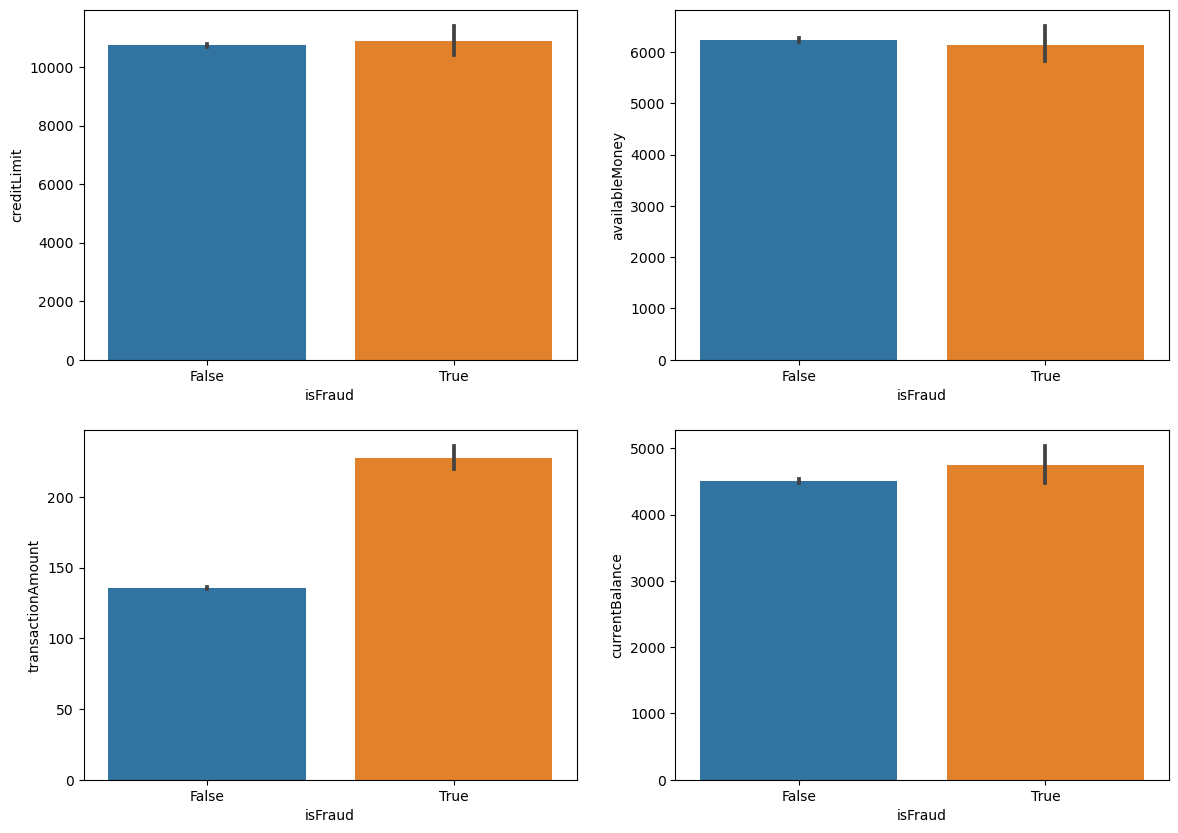

In [74]:
fig,ax = plt.subplots(2,2,figsize=(14,10))

for col,subplot in zip(df_num,ax.flatten()):
    sns.barplot(y=col,x='isFraud',data=df,ax=subplot)
plt.show()

<u>Boxplot</u>:

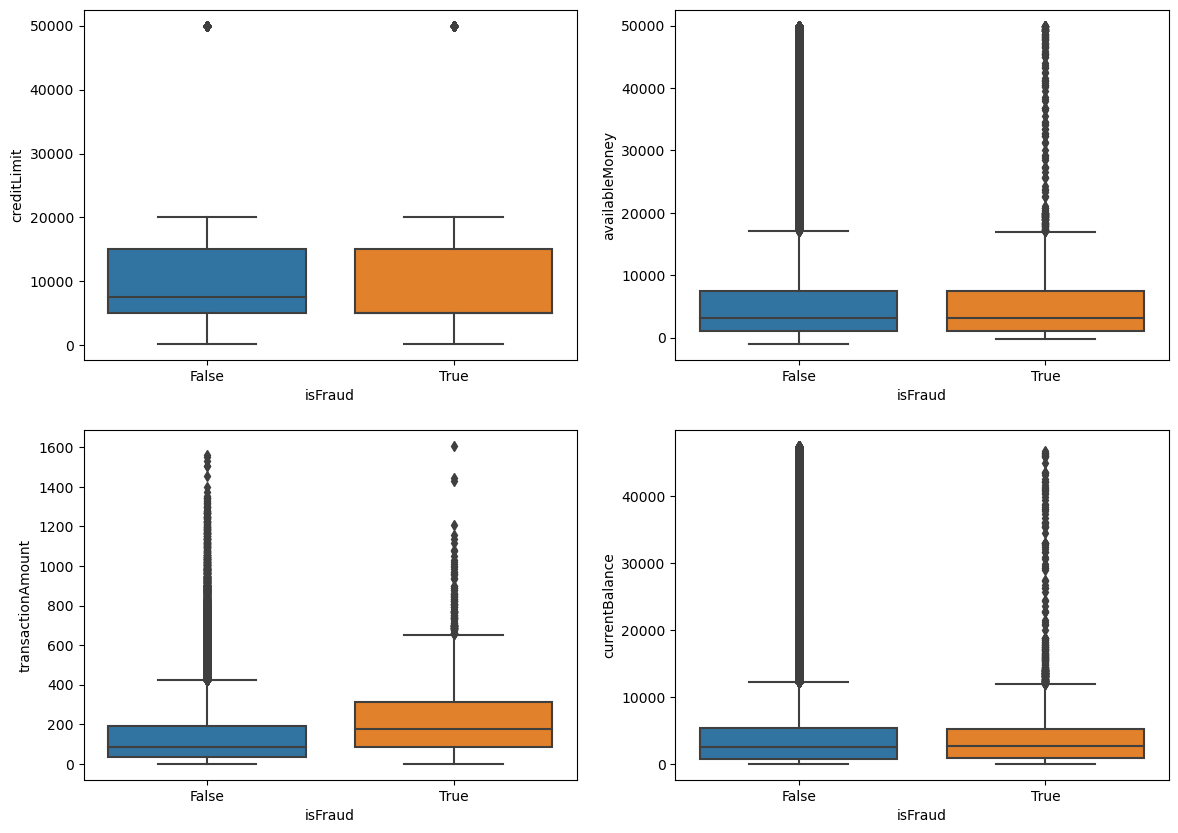

In [75]:
fig,ax = plt.subplots(2,2,figsize=(14,10))

for col,subplot in zip(df_num,ax.flatten()):
    sns.boxplot(y=col,x='isFraud',data=df,ax=subplot)
plt.show()

<b><u>Inference:</u></b>

'creditLimit' vs ‘isFraud’
- We can there is no significant difference in the distribution of ‘creditLimit’ for fraudulent and non-fraudulent transactions.
- 50% of the data of ‘creditLimit’ for the fraudulent transactions & non-fraudulent transactions lie around 5000 to 15000.

'availableMoney' vs ‘isFraud’
- We can there is no significant difference in the distribution of ‘availableMoney’ for fraudulent and non-fraudulent transactions.
- 50% of the data of ‘availableMoney’ for the fraudulent transactions lies around 1057.7 and 7425.1
- 50% of the data of ‘availableMoney’ for the non fraudulent fraudulent transactions lies around 1079.8 and 7500
- There are huge no. of outliers in both categories.

'transactionAmount' vs ‘isFraud’
- We can there is a significant much difference in the distribution of ‘transactionAmount’ for fraudulent and non-fraudulent transactions.
- 50% of the data of ‘transactionAmount’ for the fraudulent transactions lies around 86.6  and 313.3
- 50% of the data of ‘transactionAmount’ for the non fraudulent fraudulent transactions lies around 33.1 and 189.
- There are huge no. of outliers in both categories

'currentBalance' vs ‘isFraud’
- We can there is no significant in the distribution of ‘currentBalance’ for fraudulent and non-fraudulent transactions.
- 50% of the data of ‘currentBalance’ for the fraudulent transactions lies around 794.2 and 5215.8
- 50% of the data of ‘currentBalance’ for the non fraudulent fraudulent transactions lies around 699.205 and 5292.615
- There are huge no. of outliers in both categories.

#### Categorical VS Categorical

<u>Crosstab</u>:

<Figure size 1000x800 with 0 Axes>

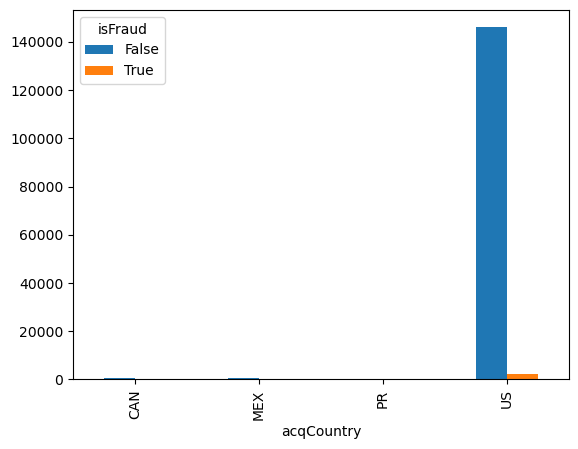

<Figure size 1000x800 with 0 Axes>

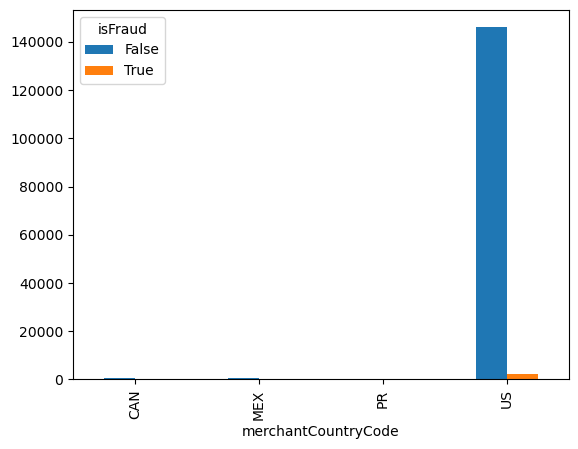

<Figure size 1000x800 with 0 Axes>

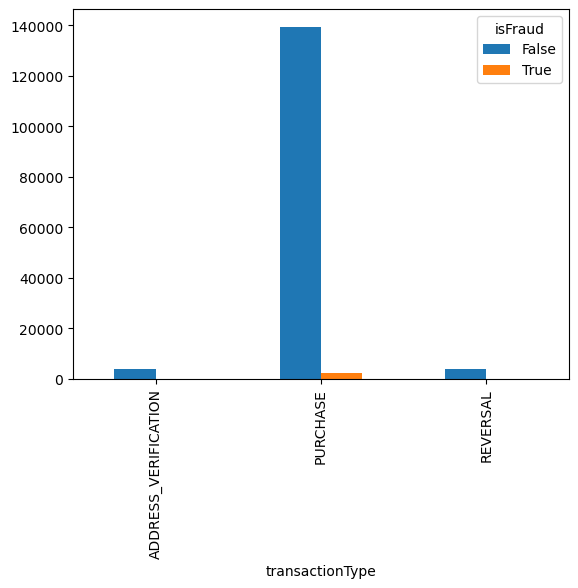

<Figure size 1000x800 with 0 Axes>

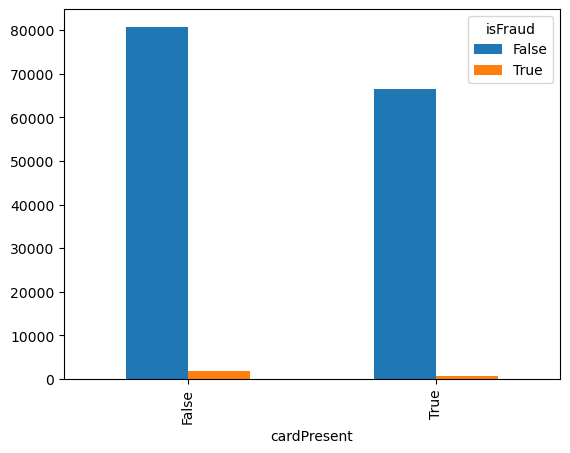

<Figure size 1000x800 with 0 Axes>

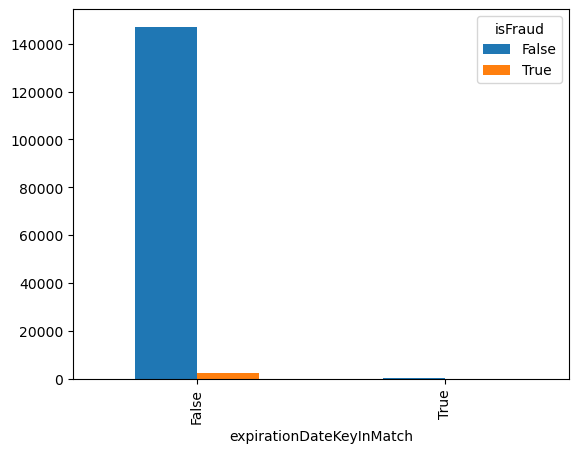

In [76]:
for col in ['acqCountry','merchantCountryCode','transactionType','cardPresent','expirationDateKeyInMatch']:
    plt.figure(figsize=(10,8))
    pd.crosstab(df[col],df['isFraud']).plot(kind='bar')
    plt.show()

<Figure size 1600x1000 with 0 Axes>

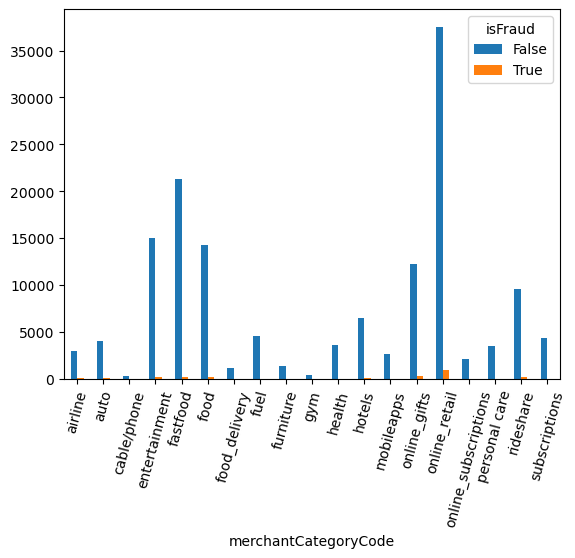

In [77]:
plt.figure(figsize=(16,10))
pd.crosstab(df['merchantCategoryCode'],df['isFraud']).plot(kind='bar')
plt.xticks(rotation=75)
plt.show()

In [65]:
# Due to huge no. of subclasses in 'merchantName' unable to represent it in a plot

<b><u>Inference:</u></b>

'acqCountry' vs ‘isFraud’
- Most fraudulent transactions(2342) are from ‘US’ followed by ‘MEX’/Mexico with 14 transactions & the least no. of fraudulent transactions(25) are from ‘PR’/Puerto-Rico.
- Most non fraudulent transactions(145944) are from ‘US’ followed by ‘MEX’/Mexico with 579 transactions & the least no. of non fraudulent transactions(285) are from ‘PR’/Puerto-Rico.


'merchantCountryCode' vs ‘isFraud’
- Most fraudulent transactions(2341) are from merchant country code ‘US’ followed by ‘Mex’ with 14 transactions & the least no. of fraudulent transactions(5) are from ‘PR’/Puerto-Rico.
- Most non fraudulent transactions(145944) are from merchant country code ‘US’ followed by ‘Mex’ with 583 transactions & the least no. of non fraudulent transactions(283) are from ‘PR’/Puerto-Rico.


'transactionType' vs ‘isFraud’
- Most fraudulent transactions(2285) are belong to purchase type ‘PURCHASE’ & the least no. of fraudulent transactions(25) are from ‘ADDRESS_VERIFICATION’.
- Most non fraudulent transactions(139470) are belong to purchase type ‘PURCHASE’ & the least no. of non fraudulent transactions(3854) are from ‘REVERSAL’.

'cardPresent' vs ‘isFraud’
- Most fraudulent transactions(1717) are where the card was physically not present & the least no. of fraudulent transactions(651) are where the card was physically present.
- Most non fraudulent transactions(80769) are where the card was physically not present & the least no. of non fraudulent transactions(66475) are where the card was physically present.


'expirationDateKeyInMatch' vs ‘isFraud’
- Most fraudulent transactions(2364) are  where the expiration date didn’t match with the one entered by the customer & the least no. of fraudulent transactions(4) are where the expiration date matched with the one entered by the customer.
- Most non fraudulent transactions(147039) are  where the expiration date didn’t match with the one entered by the customer & the least no. of non fraudulent transactions(205) are where the expiration date matched with the one entered by the customer.

<b>Numeric VS Numeric VS Numeric</b>

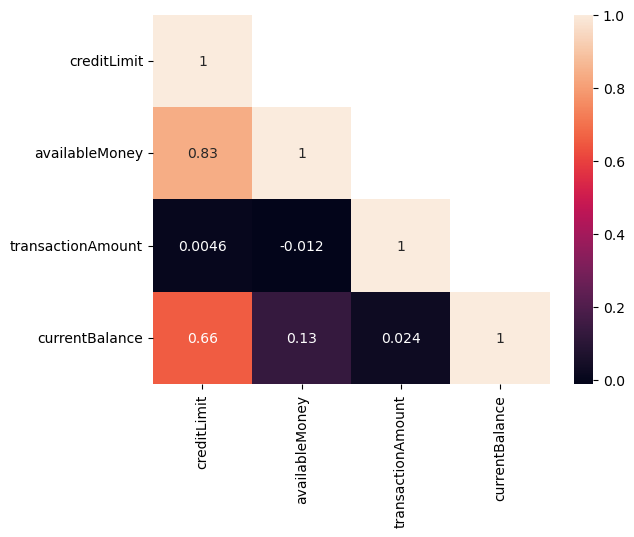

In [80]:
sns.heatmap(df_num.corr(),annot=True,mask=np.triu(df_num.corr(),k=1))
plt.show()

Inference:
   - We can infer the presence of Multi-collinearity from the above plot.
   - We can see high positive correlation(0.83) between 'creditLimit' & 'availableMoney'.
   - We can see high positive correlation(0.66) between 'creditLimit' &  'currentBalance'. 
   - We can see very weak positive correlation(0.13) between 'currentBalance' & 'availableMoney'.

### Statistical tests of significance (to find if any relationship exists between the 'x' variables and 'y' variable):

In [96]:
df_num.columns

Index(['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance'], dtype='object')

- 'creditLimit'

In [97]:
stats.ttest_ind(df['creditLimit'].loc[df['isFraud']==True],df['creditLimit'].loc[df['isFraud']==False])
# Since pvalue>0.05, there is no relation between 'creditLimit' & 'isFraud'.

TtestResult(statistic=0.6365241737153939, pvalue=0.5244358038462167, df=149610.0)

- 'availableMoney'

In [98]:
stats.ttest_ind(df['availableMoney'].loc[df['isFraud']==True],df['availableMoney'].loc[df['isFraud']==False])
# Since pvalue>0.05, there is no relation between 'availableMoney' & 'isFraud'.

TtestResult(statistic=-0.5041741018361929, pvalue=0.6141397802748866, df=149610.0)

- 'transactionAmount'

In [99]:
stats.ttest_ind(df['transactionAmount'].loc[df['isFraud']==True],df['transactionAmount'].loc[df['isFraud']==False])
# Since pvalue<0.05,  there exists a relation between 'transactionAmount' & 'isFraud'.

TtestResult(statistic=30.294493974502704, pvalue=5.51988874420541e-201, df=149610.0)

- 'currentBalance'

In [100]:
stats.ttest_ind(df['currentBalance'].loc[df['isFraud']==True],df['currentBalance'].loc[df['isFraud']==False])
# Since pvalue>0.05, there is no relation between 'currentBalance' & 'isFraud' 

TtestResult(statistic=1.8371007160126296, pvalue=0.06619701078459826, df=149610.0)

<b>Categorical variables</b>

In [101]:
df_cat.columns

Index(['merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode',
       'posConditionCode', 'merchantCategoryCode', 'transactionType',
       'cardPresent', 'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')

- 'merchantName'

In [102]:
stats.chi2_contingency(pd.crosstab(df['merchantName'],df['isFraud']))
# Since pvalue<0.05, there is a relation between 'merchantName' & 'isFraud' 

Chi2ContingencyResult(statistic=2602.3225481380564, pvalue=0.025098774205391815, dof=2463, expected_freq=array([[1.50578376e+02, 2.42162393e+00],
       [1.64356790e+02, 2.64321044e+00],
       [1.51562548e+02, 2.43745154e+00],
       ...,
       [3.18182935e+03, 5.11706548e+01],
       [8.56229982e+01, 1.37700184e+00],
       [9.15280325e+01, 1.47196749e+00]]))

- 'acqCountry'

In [103]:
stats.chi2_contingency(pd.crosstab(df['acqCountry'],df['isFraud']))
# Since pvalue>0.05, there is no relation between 'acqCountry' & 'isFraud' 

Chi2ContingencyResult(statistic=2.353034893461002, pvalue=0.5024370305856165, dof=3, expected_freq=array([[4.35988370e+02, 7.01163008e+00],
       [5.83614229e+02, 9.38577119e+00],
       [2.85409994e+02, 4.59000615e+00],
       [1.45938987e+05, 2.34701259e+03]]))

- 'merchantCountryCode'

In [89]:
stats.chi2_contingency(pd.crosstab(df['merchantCountryCode'],df['isFraud']))
# Since pvalue>0.05, there is no relation between 'acqCountry' & 'isFraud'

Chi2ContingencyResult(statistic=2.4325984699890393, pvalue=0.48759527640471056, dof=3, expected_freq=array([[4.35004198e+02, 6.99580248e+00],
       [5.87550918e+02, 9.44908162e+00],
       [2.83441649e+02, 4.55835093e+00],
       [1.45938003e+05, 2.34699676e+03]]))

- 'posEntryMode'

In [90]:
stats.chi2_contingency(pd.crosstab(df['posEntryMode'],df['isFraud']))
# Since pvalue<0.05, there exists a relation between 'posEntryMode' & 'isFraud'

Chi2ContingencyResult(statistic=400.241440476065, pvalue=2.466790695981825e-85, dof=4, expected_freq=array([[3.66938835e+04, 5.90116515e+02],
       [5.94951895e+04, 9.56810523e+02],
       [4.44964022e+04, 7.15597786e+02],
       [2.86098915e+03, 4.60108547e+01],
       [3.69753568e+03, 5.94643210e+01]]))

- 'posConditionCode'

In [91]:
stats.chi2_contingency(pd.crosstab(df['posConditionCode'],df['isFraud']))
# Since pvalue<0.05, there exists a relation between 'posConditionCode' & 'isFraud'

Chi2ContingencyResult(statistic=22.02765554883802, pvalue=1.647234284880733e-05, dof=2, expected_freq=array([[1.17838897e+05, 1.89510275e+03],
       [2.80311981e+04, 4.50801914e+02],
       [1.37390466e+03, 2.20953399e+01]]))

- 'merchantCategoryCode'

In [92]:
stats.chi2_contingency(pd.crosstab(df['merchantCategoryCode'],df['isFraud']))
# Since pvalue<0.05, there exists a relation between 'merchantCategoryCode' & 'isFraud'

Chi2ContingencyResult(statistic=726.8677685286452, pvalue=1.1225135028669137e-142, dof=18, expected_freq=array([[2.97121645e+03, 4.77835468e+01],
       [4.02821760e+03, 6.47823971e+01],
       [2.64742374e+02, 4.25762639e+00],
       [1.49171010e+04, 2.39899046e+02],
       [2.11685640e+04, 3.40436008e+02],
       [1.41907817e+04, 2.28218271e+02],
       [1.12294070e+03, 1.80593001e+01],
       [4.46519015e+03, 7.18098548e+01],
       [1.38669890e+03, 2.23010988e+01],
       [3.73985509e+02, 6.01449082e+00],
       [3.59124506e+03, 5.77549394e+01],
       [6.44731334e+03, 1.03686656e+02],
       [2.61888274e+03, 4.21172633e+01],
       [1.23533319e+04, 1.98668128e+02],
       [3.78591436e+04, 6.08856402e+02],
       [2.04117354e+03, 3.28264578e+01],
       [3.49578034e+03, 5.62196615e+01],
       [9.63898441e+03, 1.55015587e+02],
       [4.30870673e+03, 6.92932652e+01]]))

- 'transactionType'

In [93]:
stats.chi2_contingency(pd.crosstab(df['transactionType'],df['isFraud']))
# Since pvalue<0.05, there exists a relation between 'transactionType' & 'isFraud'

Chi2ContingencyResult(statistic=23.83704052609828, pvalue=6.6658021229242185e-06, dof=2, expected_freq=array([[3.88256009e+03, 6.24399112e+01],
       [1.39511358e+05, 2.24364249e+03],
       [3.85008240e+03, 6.19176002e+01]]))

- 'cardPresent'

In [94]:
stats.chi2_contingency(pd.crosstab(df['cardPresent'],df['isFraud']))
# Since pvalue<0.05, there exists a relation between 'cardPresent' & 'isFraud'

Chi2ContingencyResult(statistic=292.93698241686775, pvalue=1.1392665521580453e-65, dof=1, expected_freq=array([[81180.44397508,  1305.55602492],
       [66063.55602492,  1062.44397508]]))

- 'expirationDateKeyInMatch'

In [95]:
stats.chi2_contingency(pd.crosstab(df['expirationDateKeyInMatch'],df['isFraud']))
# Since pvalue>0.05, there exists no relation between  'expirationDateKeyInMatch' & 'isFraud'

Chi2ContingencyResult(statistic=0.011342604035680244, pvalue=0.9151843367245136, dof=1, expected_freq=array([[1.47038308e+05, 2.36469203e+03],
       [2.05692030e+02, 3.30796995e+00]]))

Dataframe to store statistical test of significance:

In [104]:
stats_test = pd.DataFrame({'creditLimit':[0.52,'No'],'availableMoney':[0.61,'No'],
                           'transactionAmount':['5.51988874420541e-201','Yes'],'currentBalance':[0.06,'No'],
                           'merchantName':[0.02,'Yes'],
                           'acqCountry':[0.5,'No'],'merchantCountryCode':[0.48,'No'],
                           'posEntryMode':['2.466790695981825e-85','Yes'],'posConditionCode':['1.647234284880733e-05','Yes'],
                           'merchantCategoryCode':['1.1225135028669137e-142','Yes'],
                           'transactionType':['6.6658021229242185e-06','Yes'],'cardPresent':['1.1392665521580453e-65','Yes'],
                           'expirationDateKeyInMatch':[0.91,'No']}).T
stats_test.columns = ['p_value','Relationship exists(p_value<0.05)']
stats_test

,p_value,Relationship exists(p_value<0.05)
creditLimit,0.52,No
availableMoney,0.61,No
transactionAmount,5.51988874420541e-201,Yes
currentBalance,0.06,No
merchantName,0.02,Yes
acqCountry,0.5,No
merchantCountryCode,0.48,No
posEntryMode,2.466790695981825e-85,Yes
posConditionCode,1.647234284880733e-05,Yes
merchantCategoryCode,1.1225135028669137e-142,Yes


In [105]:
stats_test_rel_columns = stats_test[stats_test['Relationship exists(p_value<0.05)']=='Yes'].index
stats_test_rel_columns

Index(['transactionAmount', 'merchantName', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'cardPresent'],
      dtype='object')

**Transformation**
Since the data has huge no. of outliers we are going for transformation to convert it into near normal distribution.

Before transformation:

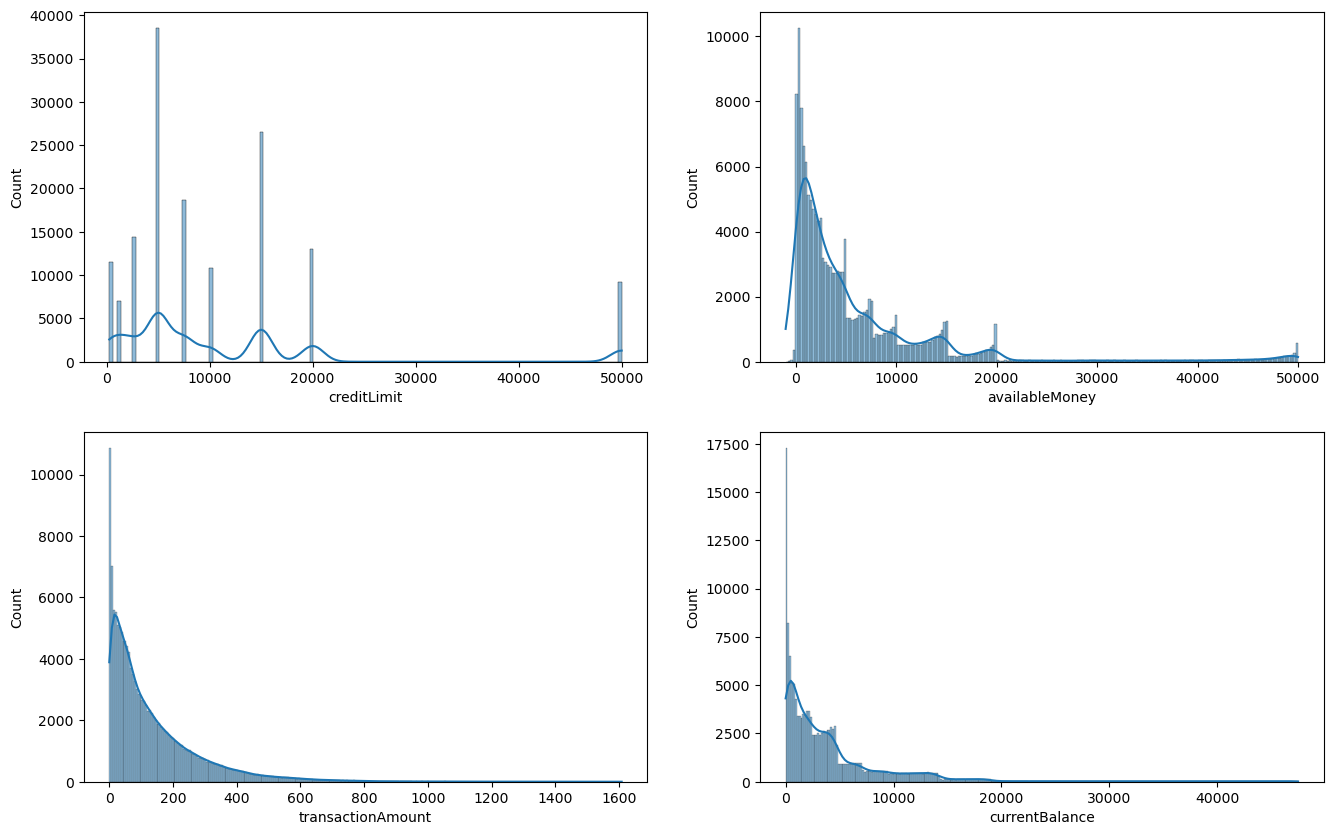

In [106]:
fig,ax = plt.subplots(2,2,figsize=(16,10))

for col,subplot in zip(df_num.columns,ax.flatten()):
    sns.histplot(x=col,data=df,kde=True,ax=subplot)
plt.show()

After transformation:

In [107]:
pt = PowerTransformer()
df_num_transformed = pt.fit_transform(df_num)
df_num_transformed = pd.DataFrame(data=df_num_transformed,columns=df_num.columns)
df_num_transformed

,creditLimit,availableMoney,transactionAmount,currentBalance
0,0.727806,-0.245175,-1.082538,1.299951
1,0.727806,1.030815,-1.559244,-0.199300
2,-0.314744,0.011488,0.079342,-1.142233
3,0.727806,0.467570,0.502031,0.800550
4,-1.444270,-0.790770,-0.842721,-0.948808
...,...,...,...,...
149607,-0.851660,-0.404690,0.738670,-1.145411
149608,-0.314744,-0.235629,-1.567856,-0.150119
149609,-1.817877,-0.955043,1.408597,-1.016422
149610,0.727806,-0.009964,0.746570,1.174588


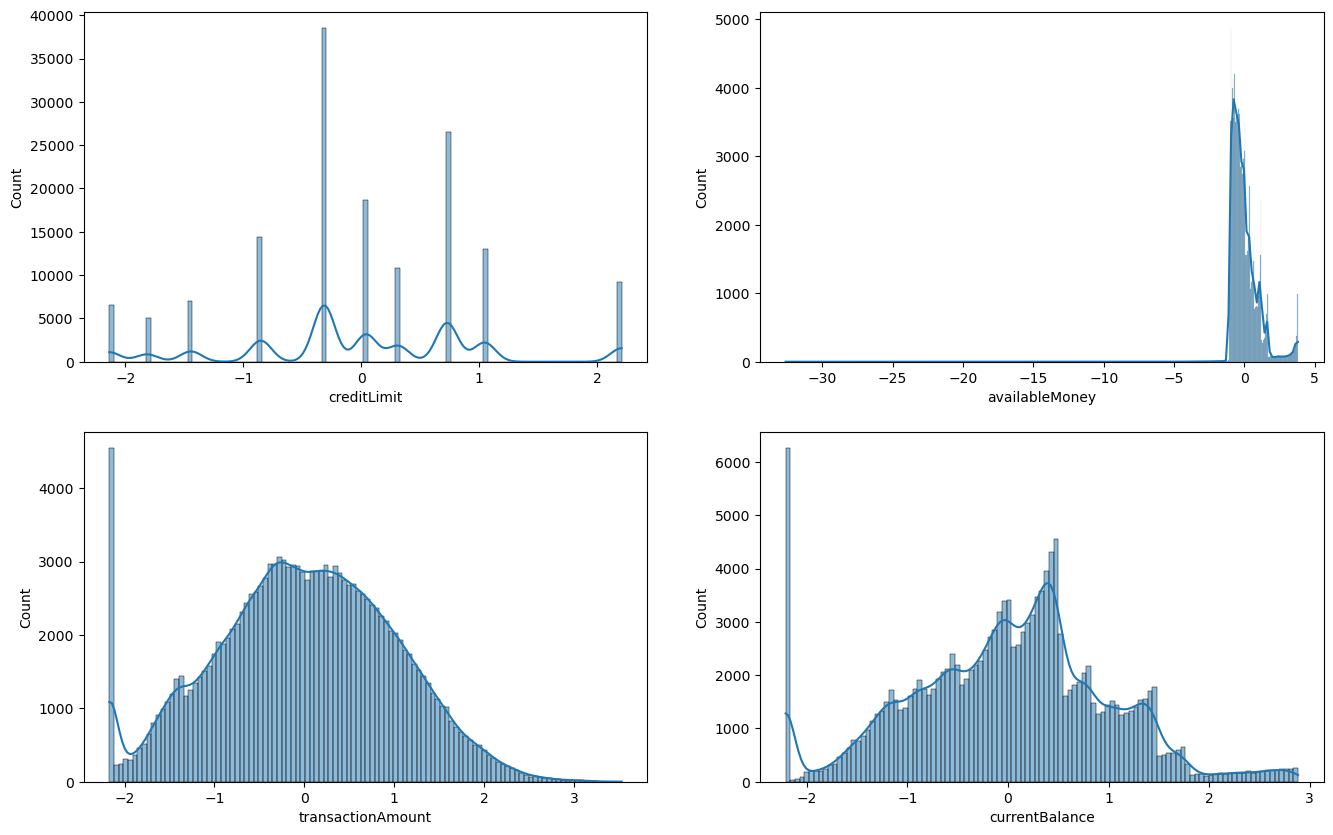

In [108]:
fig,ax = plt.subplots(2,2,figsize=(16,10))

for col,subplot in zip(df_num_transformed.columns,ax.flatten()):
    sns.histplot(x=col,data=df_num_transformed,kde=True,ax=subplot)
plt.show()

Let us bin 'merchantCategoryCode' into smaller no. of subclasses, which currently has 19 sub-classes

In [109]:
df['merchantCategoryCode'].value_counts()

merchantCategoryCode
online_retail           38468
fastfood                21509
entertainment           15157
food                    14419
online_gifts            12552
rideshare                9794
hotels                   6551
fuel                     4537
subscriptions            4378
auto                     4093
health                   3649
personal care            3552
airline                  3019
mobileapps               2661
online_subscriptions     2074
furniture                1409
food_delivery            1141
gym                       380
cable/phone               269
Name: count, dtype: int64

In [110]:
df['merchantCategoryCode'].replace(to_replace=['fastfood','food_delivery'],value='food',inplace=True)
df['merchantCategoryCode'].replace(to_replace=['online_retail','online_gifts'],value='online_purchase',inplace=True)

In [111]:
len(df['merchantCategoryCode'].value_counts().index)

16

We have reduced the no. of subclasses from 19 to 16.

# Feature engineering:

In [112]:
((df['cardCVV']==df['enteredCVV']).astype(int)).value_counts() #  we can see 1323 where there was no match

1    148289
0      1323
Name: count, dtype: int64

- Let us create a new column 'CVV_match' from 'cardCVV' & 'enteredCVV' that contains record of correct or wrong CVV entered by customer.

In [113]:
df.insert(loc=1,column='CVV_Match',value=(df['cardCVV']==df['enteredCVV']).astype(int))
df.drop(columns=['cardCVV','enteredCVV'],axis=1,inplace=True)
df['CVV_Match'] = df['CVV_Match'].astype('O')
df_cat = pd.concat((df_cat,df['CVV_Match']),axis=1)
df_cat

,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,isFraud,CVV_Match
0,Dinosaur Sandwitch Bar #303701,US,US,5.0,1.0,food,PURCHASE,True,False,False,1
1,Play Store,US,US,5.0,8.0,mobileapps,PURCHASE,False,False,False,1
2,amazon.com,US,US,9.0,1.0,online_retail,PURCHASE,False,False,True,1
3,Delta Airlines,US,US,5.0,8.0,airline,PURCHASE,False,False,False,1
4,Sunoco Gas #931794,US,US,2.0,1.0,fuel,PURCHASE,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...
149607,Rodeway Inn #105130,US,US,5.0,1.0,hotels,PURCHASE,False,False,False,1
149608,walmart.com,US,US,9.0,1.0,online_retail,PURCHASE,False,False,False,0
149609,1st Restaurant,US,US,5.0,1.0,food,PURCHASE,True,False,False,1
149610,WSC #998991,US,US,5.0,1.0,health,PURCHASE,False,False,False,1


In [114]:
stats.chi2_contingency(pd.crosstab(df['CVV_Match'],df['isFraud']))
# Since pvalue<0.05  'expirationDateKeyInMatch' & 'isFraud' are dependent variables

Chi2ContingencyResult(statistic=20.694770091349998, pvalue=5.386291691519736e-06, dof=1, expected_freq=array([[1.30206008e+03, 2.09399246e+01],
       [1.45941940e+05, 2.34706008e+03]]))

In [169]:
stats_test = pd.DataFrame({'creditLimit':[0.52,'No'],'availableMoney':[0.61,'No'],
                           'transactionAmount':['5.51988874420541e-201','Yes'],'currentBalance':[0.06,'No'],
                           'merchantName':[0.02,'Yes'],
                           'acqCountry':[0.5,'No'],'merchantCountryCode':[0.48,'No'],
                           'posEntryMode':['2.466790695981825e-85','Yes'],'posConditionCode':['1.647234284880733e-05','Yes'],
                           'merchantCategoryCode':['1.1225135028669137e-142','Yes'],
                           'transactionType':['6.6658021229242185e-06','Yes'],'cardPresent':['1.1392665521580453e-65','Yes'],
                           'expirationDateKeyInMatch':[0.91,'No'],'CVV_Match':['5.386291691519736e-06','Yes']}).T
stats_test.columns = ['p_value','Relationship exists(p_value<0.05)']
stats_test

,p_value,Relationship exists(p_value<0.05)
creditLimit,0.52,No
availableMoney,0.61,No
transactionAmount,5.51988874420541e-201,Yes
currentBalance,0.06,No
merchantName,0.02,Yes
acqCountry,0.5,No
merchantCountryCode,0.48,No
posEntryMode,2.466790695981825e-85,Yes
posConditionCode,1.647234284880733e-05,Yes
merchantCategoryCode,1.1225135028669137e-142,Yes


In [170]:
stats_test_rel_columns = stats_test[stats_test['Relationship exists(p_value<0.05)']=='Yes'].index
stats_test_rel_columns

Index(['transactionAmount', 'merchantName', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'cardPresent', 'CVV_Match'],
      dtype='object')

**Encoding**

In [118]:
df_cat

,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,isFraud,CVV_Match
0,Dinosaur Sandwitch Bar #303701,US,US,5.0,1.0,food,PURCHASE,True,False,False,1
1,Play Store,US,US,5.0,8.0,mobileapps,PURCHASE,False,False,False,1
2,amazon.com,US,US,9.0,1.0,online_retail,PURCHASE,False,False,True,1
3,Delta Airlines,US,US,5.0,8.0,airline,PURCHASE,False,False,False,1
4,Sunoco Gas #931794,US,US,2.0,1.0,fuel,PURCHASE,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...
149607,Rodeway Inn #105130,US,US,5.0,1.0,hotels,PURCHASE,False,False,False,1
149608,walmart.com,US,US,9.0,1.0,online_retail,PURCHASE,False,False,False,0
149609,1st Restaurant,US,US,5.0,1.0,food,PURCHASE,True,False,False,1
149610,WSC #998991,US,US,5.0,1.0,health,PURCHASE,False,False,False,1


In [119]:
df['isFraud'].value_counts()

isFraud
False    147244
True       2368
Name: count, dtype: int64

In [120]:
df_cat[['merchantName','acqCountry', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode','transactionType', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'CVV_Match']]

,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,isFraud,CVV_Match
0,Dinosaur Sandwitch Bar #303701,US,5.0,1.0,food,PURCHASE,True,False,False,1
1,Play Store,US,5.0,8.0,mobileapps,PURCHASE,False,False,False,1
2,amazon.com,US,9.0,1.0,online_retail,PURCHASE,False,False,True,1
3,Delta Airlines,US,5.0,8.0,airline,PURCHASE,False,False,False,1
4,Sunoco Gas #931794,US,2.0,1.0,fuel,PURCHASE,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...
149607,Rodeway Inn #105130,US,5.0,1.0,hotels,PURCHASE,False,False,False,1
149608,walmart.com,US,9.0,1.0,online_retail,PURCHASE,False,False,False,0
149609,1st Restaurant,US,5.0,1.0,food,PURCHASE,True,False,False,1
149610,WSC #998991,US,5.0,1.0,health,PURCHASE,False,False,False,1


In [121]:
le = LabelEncoder()
df_cat_encoded = df[['merchantName','acqCountry', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode','transactionType', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'CVV_Match']].apply(le.fit_transform)
df_cat_encoded

,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,isFraud,CVV_Match
0,355,3,1,0,4,1,1,0,0,1
1,1293,3,1,1,10,1,0,0,0,1
2,2445,3,2,0,11,1,0,0,1,1
3,348,3,1,1,0,1,0,0,0,1
4,1990,3,0,0,5,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
149607,1592,3,1,0,9,1,0,0,0,1
149608,2461,3,2,0,11,1,0,0,0,0
149609,3,3,1,0,4,1,1,0,0,1
149610,2223,3,1,0,8,1,0,0,0,1


In [122]:
df_cat_encoded['isFraud'].value_counts()

isFraud
0    147244
1      2368
Name: count, dtype: int64

In [123]:
df_final_encoded = pd.concat((df_num_transformed,df_cat_encoded),axis=1)
df_final_encoded

,creditLimit,availableMoney,transactionAmount,currentBalance,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,isFraud,CVV_Match
0,0.727806,-0.245175,-1.082538,1.299951,355,3,1,0,4,1,1,0,0,1
1,0.727806,1.030815,-1.559244,-0.199300,1293,3,1,1,10,1,0,0,0,1
2,-0.314744,0.011488,0.079342,-1.142233,2445,3,2,0,11,1,0,0,1,1
3,0.727806,0.467570,0.502031,0.800550,348,3,1,1,0,1,0,0,0,1
4,-1.444270,-0.790770,-0.842721,-0.948808,1990,3,0,0,5,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149607,-0.851660,-0.404690,0.738670,-1.145411,1592,3,1,0,9,1,0,0,0,1
149608,-0.314744,-0.235629,-1.567856,-0.150119,2461,3,2,0,11,1,0,0,0,0
149609,-1.817877,-0.955043,1.408597,-1.016422,3,3,1,0,4,1,1,0,0,1
149610,0.727806,-0.009964,0.746570,1.174588,2223,3,1,0,8,1,0,0,0,1


In [124]:
df_final_encoded.to_csv('df_final_encoded.csv',index=False)

<hr>

### TrainTestSplit:

In [105]:
df_final_encoded = pd.read_csv('df_final_encoded.csv')
df_final_encoded.head()

,creditLimit,availableMoney,transactionAmount,currentBalance,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,isFraud,CVV_Match
0,0.727806,-0.245175,-1.082538,1.299951,355,3,1,0,4,1,1,0,0,1
1,0.727806,1.030815,-1.559244,-0.199300,1293,3,1,1,10,1,0,0,0,1
2,-0.314744,0.011488,0.079342,-1.142233,2445,3,2,0,11,1,0,0,1,1
3,0.727806,0.467570,0.502031,0.800550,348,3,1,1,0,1,0,0,0,1
4,-1.444270,-0.790770,-0.842721,-0.948808,1990,3,0,0,5,1,1,0,0,1


In [106]:
x = df_final_encoded.drop(columns='isFraud',axis=1)
y = df_final_encoded['isFraud']
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,stratify=y,random_state=4)

In [107]:
xtrain = xtrain.reset_index(drop=True)
ytrain = ytrain.reset_index(drop=True)
xtest = xtest.reset_index(drop=True)
ytest = ytest.reset_index(drop=True)

print(xtrain.shape,ytrain.shape)
print(xtest.shape,ytest.shape)

(119689, 13) (119689,)
(29923, 13) (29923,)


**Statistical test to verify train test split has equal distribution**

In [108]:
#Null Hypothesis H0:mu1==mu2
#Alternate HYpothesis H1: mu1!=mu2

from scipy.stats import ttest_ind

pvalue = ttest_ind(ytrain,ytest).pvalue
alpha=0.05
if pvalue < alpha:
    print('Reject Null Hypothesis, data is not Equally distributed')
else:
    print('Fails to reject null hypothesis, data is equally distributed')

Fails to reject null hypothesis, data is equally distributed


**Scaling**

In [109]:
xtrain

,creditLimit,availableMoney,transactionAmount,currentBalance,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,CVV_Match
0,-0.314744,-0.592340,-0.571186,0.313123,520,3,2,0,3,1,1,0,1
1,-2.137233,-0.932404,0.569513,-2.210923,809,3,2,0,9,1,0,0,1
2,2.208624,1.192510,-0.073252,2.488373,156,3,0,0,11,1,0,0,1
3,-0.851660,-0.866796,-0.309591,-0.052924,1050,3,1,1,14,1,0,0,1
4,2.208624,2.092874,-0.067889,2.070575,778,3,1,0,9,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119684,0.727806,0.583942,1.168626,0.671915,2460,3,0,1,11,1,0,0,1
119685,-0.851660,-0.373841,0.479690,-1.574317,1050,3,2,0,14,1,0,0,1
119686,0.040403,0.081943,0.405324,-0.011140,2459,3,1,0,11,1,0,0,1
119687,0.040403,-0.422133,0.214801,0.602623,1611,3,0,0,9,1,1,0,1


In [110]:
xtrain_cat = xtrain[['merchantName','acqCountry', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'cardPresent','expirationDateKeyInMatch', 'CVV_Match']]
xtrain_cat

,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,CVV_Match
0,520,3,2,0,3,1,1,0,1
1,809,3,2,0,9,1,0,0,1
2,156,3,0,0,11,1,0,0,1
3,1050,3,1,1,14,1,0,0,1
4,778,3,1,0,9,1,1,0,1
...,...,...,...,...,...,...,...,...,...
119684,2460,3,0,1,11,1,0,0,1
119685,1050,3,2,0,14,1,0,0,1
119686,2459,3,1,0,11,1,0,0,1
119687,1611,3,0,0,9,1,1,0,1


In [111]:
xtrain_num= xtrain[['creditLimit','availableMoney','transactionAmount','currentBalance']]
xtrain_num

,creditLimit,availableMoney,transactionAmount,currentBalance
0,-0.314744,-0.592340,-0.571186,0.313123
1,-2.137233,-0.932404,0.569513,-2.210923
2,2.208624,1.192510,-0.073252,2.488373
3,-0.851660,-0.866796,-0.309591,-0.052924
4,2.208624,2.092874,-0.067889,2.070575
...,...,...,...,...
119684,0.727806,0.583942,1.168626,0.671915
119685,-0.851660,-0.373841,0.479690,-1.574317
119686,0.040403,0.081943,0.405324,-0.011140
119687,0.040403,-0.422133,0.214801,0.602623


In [112]:
ss = StandardScaler()

xtrain_num_scaled = pd.DataFrame(data=ss.fit_transform(xtrain_num),columns=xtrain_num.columns)
xtrain_num_scaled

,creditLimit,availableMoney,transactionAmount,currentBalance
0,-0.313153,-0.590030,-0.572874,0.313629
1,-2.135052,-0.929544,0.567579,-2.209782
2,2.209399,1.191927,-0.075048,2.488330
3,-0.849895,-0.864042,-0.311336,-0.052327
4,2.209399,2.090833,-0.069686,2.070639
...,...,...,...,...
119684,0.729060,0.584345,1.166563,0.672331
119685,-0.849895,-0.371886,0.477775,-1.573336
119686,0.041879,0.083160,0.403425,-0.010553
119687,0.041879,-0.420099,0.212943,0.603056


In [113]:
xtrain_scaled = pd.concat((xtrain_num_scaled,xtrain_cat),axis=1)
xtrain_scaled

,creditLimit,availableMoney,transactionAmount,currentBalance,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,CVV_Match
0,-0.313153,-0.590030,-0.572874,0.313629,520,3,2,0,3,1,1,0,1
1,-2.135052,-0.929544,0.567579,-2.209782,809,3,2,0,9,1,0,0,1
2,2.209399,1.191927,-0.075048,2.488330,156,3,0,0,11,1,0,0,1
3,-0.849895,-0.864042,-0.311336,-0.052327,1050,3,1,1,14,1,0,0,1
4,2.209399,2.090833,-0.069686,2.070639,778,3,1,0,9,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119684,0.729060,0.584345,1.166563,0.672331,2460,3,0,1,11,1,0,0,1
119685,-0.849895,-0.371886,0.477775,-1.573336,1050,3,2,0,14,1,0,0,1
119686,0.041879,0.083160,0.403425,-0.010553,2459,3,1,0,11,1,0,0,1
119687,0.041879,-0.420099,0.212943,0.603056,1611,3,0,0,9,1,1,0,1


- xtest

In [114]:
xtest

,creditLimit,availableMoney,transactionAmount,currentBalance,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,CVV_Match
0,2.208624,2.221036,-0.832331,1.993190,1550,3,2,0,9,1,1,0,1
1,0.040403,0.286131,1.134981,-0.636623,1450,3,2,0,4,1,1,0,1
2,2.208624,1.141442,0.796290,2.506966,1632,3,0,1,9,1,0,0,1
3,-0.851660,-0.463146,-1.535435,-0.799396,7,3,4,0,4,1,0,0,1
4,-0.851660,-0.931758,0.914413,-0.005031,1048,3,1,0,4,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29918,0.312760,0.287408,-1.139509,0.232028,2445,3,1,1,11,1,0,0,1
29919,0.040403,0.155103,0.830663,-0.175840,589,3,0,0,11,1,0,0,1
29920,0.312760,0.193184,0.440635,0.374744,157,3,1,0,6,1,1,0,1
29921,-0.314744,-0.600302,0.213491,0.319875,33,3,1,0,3,1,1,0,1


In [115]:
xtest_num= xtest[['creditLimit','availableMoney','transactionAmount','currentBalance']]
xtest_num

,creditLimit,availableMoney,transactionAmount,currentBalance
0,2.208624,2.221036,-0.832331,1.993190
1,0.040403,0.286131,1.134981,-0.636623
2,2.208624,1.141442,0.796290,2.506966
3,-0.851660,-0.463146,-1.535435,-0.799396
4,-0.851660,-0.931758,0.914413,-0.005031
...,...,...,...,...
29918,0.312760,0.287408,-1.139509,0.232028
29919,0.040403,0.155103,0.830663,-0.175840
29920,0.312760,0.193184,0.440635,0.374744
29921,-0.314744,-0.600302,0.213491,0.319875


In [116]:
xtest_cat = xtest[['merchantName','acqCountry', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'cardPresent','expirationDateKeyInMatch', 'CVV_Match']]
xtest_cat

,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,CVV_Match
0,1550,3,2,0,9,1,1,0,1
1,1450,3,2,0,4,1,1,0,1
2,1632,3,0,1,9,1,0,0,1
3,7,3,4,0,4,1,0,0,1
4,1048,3,1,0,4,1,1,0,1
...,...,...,...,...,...,...,...,...,...
29918,2445,3,1,1,11,1,0,0,1
29919,589,3,0,0,11,1,0,0,1
29920,157,3,1,0,6,1,1,0,1
29921,33,3,1,0,3,1,1,0,1


In [117]:
ss = StandardScaler()

xtest_num_scaled = pd.DataFrame(data=ss.fit_transform(xtest_num),columns=xtest_num.columns)
xtest_num_scaled

,creditLimit,availableMoney,transactionAmount,currentBalance
0,2.205572,2.230206,-0.825824,1.992868
1,0.034489,0.282572,1.143253,-0.639608
2,2.205572,1.143510,0.804259,2.507164
3,-0.858751,-0.471635,-1.529558,-0.802545
4,-0.858751,-0.943330,0.922487,-0.007377
...,...,...,...,...
29918,0.307206,0.283857,-1.133277,0.229922
29919,0.034489,0.150682,0.838663,-0.178358
29920,0.307206,0.189013,0.448285,0.372783
29921,-0.321126,-0.609693,0.220937,0.317858


In [118]:
xtest_scaled = pd.concat((xtest_num_scaled,xtest_cat),axis=1)
xtest_scaled

,creditLimit,availableMoney,transactionAmount,currentBalance,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,CVV_Match
0,2.205572,2.230206,-0.825824,1.992868,1550,3,2,0,9,1,1,0,1
1,0.034489,0.282572,1.143253,-0.639608,1450,3,2,0,4,1,1,0,1
2,2.205572,1.143510,0.804259,2.507164,1632,3,0,1,9,1,0,0,1
3,-0.858751,-0.471635,-1.529558,-0.802545,7,3,4,0,4,1,0,0,1
4,-0.858751,-0.943330,0.922487,-0.007377,1048,3,1,0,4,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29918,0.307206,0.283857,-1.133277,0.229922,2445,3,1,1,11,1,0,0,1
29919,0.034489,0.150682,0.838663,-0.178358,589,3,0,0,11,1,0,0,1
29920,0.307206,0.189013,0.448285,0.372783,157,3,1,0,6,1,1,0,1
29921,-0.321126,-0.609693,0.220937,0.317858,33,3,1,0,3,1,1,0,1


In [157]:
perf_score = pd.DataFrame(columns=["Model", "Accuracy", "Recall", "Precision", "F1 Score", "TN", "FN", "FP", "TP"])

def per_measures(model, test, pred):
    accuracy = accuracy_score(test, pred)
    f1score = f1_score(test, pred, average='weighted')  # Set average to 'weighted'
    recall = recall_score(test, pred, average='weighted')  # Set average to 'weighted'
    precision = precision_score(test, pred, average='weighted', zero_division=1)  # Set average to 'weighted'
    cm = confusion_matrix(test, pred)

    # Extract values from the confusion matrix for each class
    tn = cm[0, 0]
    fn = cm[1, 0]
    fp = cm[0, 1]
    tp = cm[1, 1]

    return accuracy, recall, precision, f1score, tn, fn, fp, tp

def update_performance(name, model, test, pred):
    global perf_score
    accuracy, recall, precision, f1score, tn, fn, fp, tp = per_measures(model, test, pred)
    new_row = {'Model': name,
               'Accuracy': accuracy,
               'Recall': recall,
               'Precision': precision,
               'F1 Score': f1score,
               'TN': tn,
               'FN': fn,
               'FP': fp,
               'TP': tp}
    perf_score = pd.concat([perf_score, pd.DataFrame([new_row])], ignore_index=True)

In [120]:
ytest.value_counts() # distribution of target variable in 'ytest'

isFraud
0    29449
1      474
Name: count, dtype: int64

### Base model:

### Logitmodel:

In [127]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(xtrain_scaled,ytrain)
ypred_lr_test = lr_model.predict(xtest_scaled)
ypred_lr_train = lr_model.predict(xtrain_scaled)

- Model evaluation:

In [128]:
confusion_matrix(ytest,ypred_lr_test) 

array([[29449,     0],
       [  474,     0]], dtype=int64)

In [129]:
confusion_matrix(ytrain,ypred_lr_train) 

array([[117795,      0],
       [  1894,      0]], dtype=int64)

- Update Model performance:

In [158]:
update_performance("Logistic Regression [Base model] - Test", lr_model, ytest, ypred_lr_test)

In [159]:
update_performance("Logistic Regression [Base model] - Train", lr_model, ytrain, ypred_lr_train)

In [160]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score,TN,FN,FP,TP
0,Logistic Regression [Base model] - Test,0.984159,0.984159,0.984410,0.976302,29449,474,0,0
1,Logistic Regression [Base model] - Train,0.984176,0.984176,0.984426,0.976327,117795,1894,0,0


- Multi-collinearity check:<br>
i) Condition number:

In [133]:
coeff_matrix = lr_model.coef_
condition_number = np.linalg.cond(coeff_matrix)

print("Condition number:", condition_number)

Condition number: 1.0


ii) Variance Inflation Factor:

In [134]:
xtrain_scaled_df = pd.DataFrame(xtrain_scaled, columns=xtrain_scaled.columns)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = xtrain_scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(xtrain_scaled_df.values, i) for i in range(xtrain_scaled_df.shape[1])]

print(vif_data)

                     Feature        VIF
0                creditLimit   7.782454
1             availableMoney   5.026059
2          transactionAmount   1.068794
3             currentBalance   3.143482
4               merchantName   4.692989
5                 acqCountry  84.544303
6               posEntryMode   2.637539
7           posConditionCode   1.236118
8       merchantCategoryCode   9.522780
9            transactionType  20.533731
10               cardPresent   3.466987
11  expirationDateKeyInMatch   1.003344
12                 CVV_Match  75.628245


In [135]:
vif_data[vif_data['VIF']>5]

,Feature,VIF
0,creditLimit,7.782454
1,availableMoney,5.026059
5,acqCountry,84.544303
8,merchantCategoryCode,9.522780
9,transactionType,20.533731
12,CVV_Match,75.628245


In [136]:
vif_data[vif_data['VIF']<5] # columns without any multicollinearity

,Feature,VIF
2,transactionAmount,1.068794
3,currentBalance,3.143482
4,merchantName,4.692989
6,posEntryMode,2.637539
7,posConditionCode,1.236118
10,cardPresent,3.466987
11,expirationDateKeyInMatch,1.003344


In [137]:
vif_columns = vif_data['Feature'][vif_data['VIF']<5].values
vif_columns

array(['transactionAmount', 'currentBalance', 'merchantName',
       'posEntryMode', 'posConditionCode', 'cardPresent',
       'expirationDateKeyInMatch'], dtype=object)

<b>Build a Logistic regression model with (vif) columns with no multi-collinearity</b>

In [138]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(xtrain_scaled[vif_columns],ytrain)
ypred_lr_test_vif = lr_model.predict(xtest_scaled[vif_columns])
ypred_lr_train_vif = lr_model.predict(xtrain_scaled[vif_columns])

- Model evaluation:

In [139]:
confusion_matrix(ytest,ypred_lr_test_vif) 

array([[29449,     0],
       [  474,     0]], dtype=int64)

In [140]:
confusion_matrix(ytrain,ypred_lr_train_vif) 

array([[117795,      0],
       [  1894,      0]], dtype=int64)

### Statsmodel:

In [141]:
import statsmodels.api as sm

c_xtrain = sm.add_constant(xtrain_scaled)

# Fit logistic regression model
stats_logit_model = sm.Logit(ytrain, c_xtrain)
stats_logit = stats_logit_model.fit()

# Predict on test set
c_xtrain = sm.add_constant(xtest_scaled)
ypred_lr = stats_logit.predict(c_xtrain)

# Converting probabilities to classes
ypred_lr_classes = (ypred_lr > 0.5).astype(int)

Optimization terminated successfully.
         Current function value: 0.077013
         Iterations 9


<b> Detect the significant columns (pvalue<0.05)</b>

In [142]:
stats_logit.pvalues

const                        3.151289e-14
creditLimit                  8.001177e-01
availableMoney               7.736892e-01
transactionAmount           4.531619e-146
currentBalance               7.251854e-01
merchantName                 7.935501e-01
acqCountry                   4.960284e-01
posEntryMode                 5.961469e-11
posConditionCode             2.201051e-02
merchantCategoryCode         6.120923e-02
transactionType              1.875278e-01
cardPresent                  1.340410e-42
expirationDateKeyInMatch     8.443590e-02
CVV_Match                    2.030515e-05
dtype: float64

In [143]:
stats_logit.pvalues[stats_logit.pvalues<0.05].index[1:]

Index(['transactionAmount', 'posEntryMode', 'posConditionCode', 'cardPresent',
       'CVV_Match'],
      dtype='object')

In [144]:
stats_model_sig_columns = list(stats_logit.pvalues[stats_logit.pvalues<0.05].index[1:])
stats_model_sig_columns

['transactionAmount',
 'posEntryMode',
 'posConditionCode',
 'cardPresent',
 'CVV_Match']

<b>Build a Logistic regression model with significant columns</b>

In [145]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(xtrain_scaled[stats_model_sig_columns],ytrain)
ypred_lr_test = lr_model.predict(xtest_scaled[stats_model_sig_columns])
ypred_lr_train = lr_model.predict(xtrain_scaled[stats_model_sig_columns])

In [146]:
confusion_matrix(ytest,ypred_lr_test) 

array([[29449,     0],
       [  474,     0]], dtype=int64)

In [147]:
confusion_matrix(ytrain,ypred_lr_train) 

array([[117795,      0],
       [  1894,      0]], dtype=int64)

<hr>

## Decision tree: 

In [148]:
ytest.value_counts()

isFraud
0    29449
1      474
Name: count, dtype: int64

- Model with scaled data:

In [149]:
from sklearn.tree import DecisionTreeClassifier
dt_entropy = DecisionTreeClassifier(criterion='entropy',random_state=4)
dt_entropy_model = dt_entropy.fit(xtrain_scaled,ytrain)
ypred_dt_test_scaled = dt_entropy_model.predict(xtest_scaled)
ypred_dt_train_scaled = dt_entropy_model.predict(xtrain_scaled)

Model performance evaluation:

In [150]:
confusion_matrix(ytest,ypred_dt_test_scaled) 

array([[28930,   519],
       [  447,    27]], dtype=int64)

In [151]:
confusion_matrix(ytrain,ypred_dt_train_scaled) 

array([[117795,      0],
       [     0,   1894]], dtype=int64)

- Model without scaled data:

In [152]:
from sklearn.tree import DecisionTreeClassifier
dt_entropy = DecisionTreeClassifier(criterion='entropy',random_state=4)
dt_entropy_model = dt_entropy.fit(xtrain,ytrain)
ypred_dt_test = dt_entropy_model.predict(xtest)
ypred_dt_train = dt_entropy_model.predict(xtrain)

In [153]:
confusion_matrix(ytest,ypred_dt_test) # Model performs well without scaled data

array([[28941,   508],
       [  447,    27]], dtype=int64)

In [154]:
confusion_matrix(ytrain,ypred_dt_train) 

array([[117795,      0],
       [     0,   1894]], dtype=int64)

<b>Inference:</b>
   - Model performance is better when we use non scaled data. Hence going forward we will use normal data and ignore the scaled data.

In [161]:
update_performance("Decision Tree [base model] - Test", dt_entropy_model, ytest, ypred_dt_test)

In [162]:
update_performance("Decision Tree [base model] - Train", dt_entropy_model, ytrain, ypred_dt_train)

In [163]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score,TN,FN,FP,TP
0,Logistic Regression [Base model] - Test,0.984159,0.984159,0.984410,0.976302,29449,474,0,0
1,Logistic Regression [Base model] - Train,0.984176,0.984176,0.984426,0.976327,117795,1894,0,0
2,Decision Tree [base model] - Test,0.968085,0.968085,0.969989,0.969033,28941,447,508,27
3,Decision Tree [base model] - Train,1.000000,1.000000,1.000000,1.000000,117795,0,0,1894


<hr>

- Model with statistically significant columns

In [164]:
stats_test_rel_columns = ['transactionAmount', 'merchantName', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType', 'cardPresent', 'CVV_Match']

i) Statistically related columns(columns that have a relation to target variable (using independent t test & Chi square contingency test)):

In [165]:
from sklearn.tree import DecisionTreeClassifier
dt_entropy = DecisionTreeClassifier(criterion='entropy',random_state=4)
dt_entropy_model = dt_entropy.fit(xtrain[stats_test_rel_columns],ytrain)
ypred_dt_test = dt_entropy_model.predict(xtest[stats_test_rel_columns])
ypred_dt_train = dt_entropy_model.predict(xtrain[stats_test_rel_columns])

Model performance evaluation:

In [166]:
confusion_matrix(ytest,ypred_dt_test) 

array([[28968,   481],
       [  453,    21]], dtype=int64)

In [167]:
confusion_matrix(ytrain,ypred_dt_train) 

array([[117795,      0],
       [    22,   1872]], dtype=int64)

ii) Stats model significant columns: (columns that are significant (using pvalue after building a stats model))

In [168]:
stats_model_sig_columns

['transactionAmount',
 'posEntryMode',
 'posConditionCode',
 'cardPresent',
 'CVV_Match']

In [169]:
from sklearn.tree import DecisionTreeClassifier
dt_entropy = DecisionTreeClassifier(criterion='entropy',random_state=4)
dt_entropy_model = dt_entropy.fit(xtrain[stats_model_sig_columns],ytrain)
ypred_dt_test = dt_entropy_model.predict(xtest[stats_model_sig_columns])
ypred_dt_train = dt_entropy_model.predict(xtrain[stats_model_sig_columns])

Model performance evaluation:

In [170]:
confusion_matrix(ytest,ypred_dt_test) 

array([[29032,   417],
       [  443,    31]], dtype=int64)

In [171]:
confusion_matrix(ytrain,ypred_dt_train) 

array([[117792,      3],
       [   348,   1546]], dtype=int64)

In [172]:
update_performance("Decision Tree [significant columns] - Test", dt_entropy_model, ytest, ypred_dt_test)

In [173]:
update_performance("Decision Tree [ significant columns] - Train", dt_entropy_model, ytrain, ypred_dt_train)

In [174]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score,TN,FN,FP,TP
0,Logistic Regression [Base model] - Test,0.984159,0.984159,0.984410,0.976302,29449,474,0,0
1,Logistic Regression [Base model] - Train,0.984176,0.984176,0.984426,0.976327,117795,1894,0,0
2,Decision Tree [base model] - Test,0.968085,0.968085,0.969989,0.969033,28941,447,508,27
3,Decision Tree [base model] - Train,1.000000,1.000000,1.000000,1.000000,117795,0,0,1894
4,Decision Tree [significant columns] - Test,0.971260,0.971260,0.970464,0.970861,29032,443,417,31
5,Decision Tree [ significant columns] - Train,0.997067,0.997067,0.997070,0.996923,117792,348,3,1546


iii) VIF columns (columns without any Multi-collinearity)

In [175]:
from sklearn.tree import DecisionTreeClassifier
dt_entropy = DecisionTreeClassifier(criterion='entropy',random_state=4)
dt_entropy_model = dt_entropy.fit(xtrain[vif_columns],ytrain)
ypred_dt_test = dt_entropy_model.predict(xtest[vif_columns])
ypred_dt_train = dt_entropy_model.predict(xtrain[vif_columns])

Model performance evaluation:

In [176]:
confusion_matrix(ytest,ypred_dt_test) 

array([[29008,   441],
       [  441,    33]], dtype=int64)

In [177]:
confusion_matrix(ytrain,ypred_dt_train) 

array([[117795,      0],
       [     0,   1894]], dtype=int64)

#### Grid search CV:

Note:
   - If real world project we could run a more intensive Grid search CV to find the best hyper parameters to fine tune the model to avoid the overfitting in decision tree even more.

In [178]:
from sklearn.tree import DecisionTreeClassifier
dt_entropy = DecisionTreeClassifier(criterion='entropy',random_state=4,max_depth=30,min_samples_leaf=10,min_samples_split=80)
dt_entropy_model = dt_entropy.fit(xtrain[stats_model_sig_columns],ytrain)
ypred_dt_test = dt_entropy_model.predict(xtest[stats_model_sig_columns])
ypred_dt_train = dt_entropy_model.predict(xtrain[stats_model_sig_columns])

In [179]:
confusion_matrix(ytest,ypred_dt_test) 

array([[29449,     0],
       [  474,     0]], dtype=int64)

In [180]:
confusion_matrix(ytrain,ypred_dt_train) 

array([[117795,      0],
       [  1894,      0]], dtype=int64)

## Random forest:

- Entropy:

In [181]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators =100,criterion='entropy',random_state=4)
rf_model_entropy = rf.fit(xtrain[stats_model_sig_columns],ytrain)
ypred_rf_entropy_test = rf_model_entropy.predict(xtest[stats_model_sig_columns])
ypred_rf_entropy_train = rf_model_entropy.predict(xtrain[stats_model_sig_columns])

Model performance evaluation:

In [182]:
confusion_matrix(ytest,ypred_rf_entropy_test) 

array([[29064,   385],
       [  442,    32]], dtype=int64)

In [183]:
confusion_matrix(ytrain,ypred_rf_entropy_train) 

array([[117779,     16],
       [   344,   1550]], dtype=int64)

In [184]:
update_performance("Random forest [significant columns] - Test", rf_model_entropy, ytest, ypred_rf_entropy_test)

In [185]:
update_performance("Random forest [significant columns] - Train", rf_model_entropy, ytrain, ypred_rf_entropy_train)

In [186]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score,TN,FN,FP,TP
0,Logistic Regression [Base model] - Test,0.984159,0.984159,0.984410,0.976302,29449,474,0,0
1,Logistic Regression [Base model] - Train,0.984176,0.984176,0.984426,0.976327,117795,1894,0,0
2,Decision Tree [base model] - Test,0.968085,0.968085,0.969989,0.969033,28941,447,508,27
3,Decision Tree [base model] - Train,1.000000,1.000000,1.000000,1.000000,117795,0,0,1894
4,Decision Tree [significant columns] - Test,0.971260,0.971260,0.970464,0.970861,29032,443,417,31
5,Decision Tree [ significant columns] - Train,0.997067,0.997067,0.997070,0.996923,117792,348,3,1546
6,Random forest [significant columns] - Test,0.972362,0.972362,0.970632,0.971492,29064,442,385,32
7,Random forest [significant columns] - Train,0.996992,0.996992,0.996972,0.996852,117779,344,16,1550


- Gini

In [187]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators =100,criterion='gini',random_state=4)
rf_model_gini = rf.fit(xtrain[stats_model_sig_columns],ytrain)
ypred_rf_gini_test = rf_model_gini.predict(xtest[stats_model_sig_columns])
ypred_rf_gini_train = rf_model_gini.predict(xtrain[stats_model_sig_columns])

Model performance evaluation:

In [188]:
confusion_matrix(ytest,ypred_rf_gini_test) 

array([[29063,   386],
       [  442,    32]], dtype=int64)

In [189]:
confusion_matrix(ytrain,ypred_rf_gini_train) 

array([[117779,     16],
       [   344,   1550]], dtype=int64)

<b>Finding the best feature using Random forest</b>:

In [190]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=4)
rf_model_entropy = rf.fit(xtrain, ytrain)


feature_importances = rf_model_entropy.feature_importances_

feature_importance_dict = dict(zip(xtrain.columns, feature_importances))

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)


print("Most significant parameters:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Most significant parameters:
transactionAmount: 0.2511621273771356
currentBalance: 0.21385713921572547
availableMoney: 0.2083409589856852
merchantName: 0.14444081476955403
creditLimit: 0.05670363594093739
merchantCategoryCode: 0.0407490765784935
posEntryMode: 0.039690216076100356
posConditionCode: 0.018892540956502935
cardPresent: 0.011097299304058212
transactionType: 0.0067960493980135685
CVV_Match: 0.0038722650180392447
acqCountry: 0.003656775082224681
expirationDateKeyInMatch: 0.0007411012975298365


Visualize the features in terms of significance:

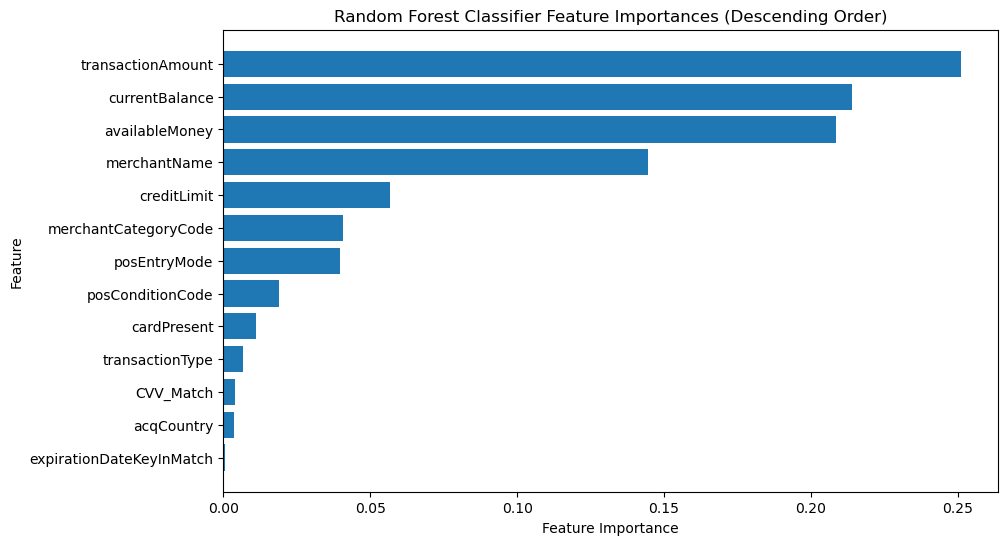

In [191]:
# Get feature importances
feature_importances = rf_model_entropy.feature_importances_

# Create a dictionary mapping feature names to their importance scores
feature_importance_dict = dict(zip(xtrain.columns, feature_importances))

# Sort the dictionary by importance scores in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract feature names and importances
features = [feat for feat, _ in sorted_feature_importance]
importances = [imp for _, imp in sorted_feature_importance]

# Plotting the feature importances in descending order
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Classifier Feature Importances (Descending Order)')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.show()

<b>Recursive Feature Elimination</b> To find the significant features

In [192]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=4)

rfe = RFE(estimator=rf_classifier, n_features_to_select=5)

rfe.fit(xtrain, ytrain)

selected_features_mask = rfe.support_

significant_variables = xtrain.columns[selected_features_mask]

print("Significant Variables:")
print(significant_variables)

Significant Variables:
Index(['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance',
       'merchantName'],
      dtype='object')


<b>Random Forest with the rfe significant features</b>

In [193]:
rfe_sig_columns = ['creditLimit','availableMoney','transactionAmount','currentBalance','merchantName']

In [194]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators =100,criterion='entropy',random_state=4)
rf_model_entropy = rf.fit(xtrain[rfe_sig_columns],ytrain)
ypred_rf_entropy_test = rf_model_entropy.predict(xtest[rfe_sig_columns])
ypred_rf_entropy_train = rf_model_entropy.predict(xtrain[rfe_sig_columns])

Model performance evaluation:

In [195]:
confusion_matrix(ytest,ypred_rf_entropy_test) 

array([[29441,     8],
       [  469,     5]], dtype=int64)

In [196]:
confusion_matrix(ytrain,ypred_rf_entropy_train) 

array([[117795,      0],
       [     8,   1886]], dtype=int64)

## Adaboost:

- Base model for ADAboost:

In [197]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators =100,criterion='entropy',random_state=4)
rf_model_entropy = rf.fit(xtrain[stats_model_sig_columns],ytrain)
ypred_rf_entropy_test = rf_model_entropy.predict(xtest[stats_model_sig_columns])
ypred_rf_entropy_train = rf_model_entropy.predict(xtrain[stats_model_sig_columns])

Model performance evaluation:

In [198]:
confusion_matrix(ytest,ypred_rf_entropy_test) 

array([[29064,   385],
       [  442,    32]], dtype=int64)

In [199]:
confusion_matrix(ytrain,ypred_rf_entropy_train) 

array([[117779,     16],
       [   344,   1550]], dtype=int64)

- Build Adaboost model:

In [200]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(estimator=rf_model_entropy,n_estimators=100,random_state=4)
ada_model = ada.fit(xtrain[stats_model_sig_columns],ytrain)
ypred_ada_test = ada_model.predict(xtest[stats_model_sig_columns])
ypred_ada_train = ada_model.predict(xtrain[stats_model_sig_columns])

Model performance evaluation:

In [203]:
confusion_matrix(ytest,ypred_ada_test) 

array([[29059,   390],
       [  443,    31]], dtype=int64)

In [204]:
confusion_matrix(ytrain,ypred_ada_train) 

array([[117789,      6],
       [   345,   1549]], dtype=int64)

- Update model performance:

In [205]:
update_performance("Adaboost [significant columns] - Test", ada_model, ytest, ypred_ada_test)

In [206]:
update_performance("Adaboost [significant columns] - Train", ada_model, ytrain, ypred_ada_train)

In [207]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score,TN,FN,FP,TP
0,Logistic Regression [Base model] - Test,0.984159,0.984159,0.984410,0.976302,29449,474,0,0
1,Logistic Regression [Base model] - Train,0.984176,0.984176,0.984426,0.976327,117795,1894,0,0
2,Decision Tree [base model] - Test,0.968085,0.968085,0.969989,0.969033,28941,447,508,27
3,Decision Tree [base model] - Train,1.000000,1.000000,1.000000,1.000000,117795,0,0,1894
4,Decision Tree [significant columns] - Test,0.971260,0.971260,0.970464,0.970861,29032,443,417,31
5,Decision Tree [ significant columns] - Train,0.997067,0.997067,0.997070,0.996923,117792,348,3,1546
6,Random forest [significant columns] - Test,0.972362,0.972362,0.970632,0.971492,29064,442,385,32
7,Random forest [significant columns] - Train,0.996992,0.996992,0.996972,0.996852,117779,344,16,1550
8,Adaboost [significant columns] - Test,0.972162,0.972162,0.970548,0.971350,29059,443,390,31
9,Adaboost [significant columns] - Train,0.997067,0.997067,0.997065,0.996925,117789,345,6,1549


## Gradient Boosting:

In [208]:
from sklearn.ensemble import GradientBoostingClassifier

In [209]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100,random_state=4)
gb_model = gb.fit(xtrain[stats_model_sig_columns],ytrain)
ypred_gb_test = gb_model.predict(xtest[stats_model_sig_columns])
ypred_gb_train = gb_model.predict(xtrain[stats_model_sig_columns])

Model performance evaluation:

In [210]:
confusion_matrix(ytest,ypred_gb_test) 

array([[29444,     5],
       [  474,     0]], dtype=int64)

In [211]:
confusion_matrix(ytrain,ypred_gb_train) 

array([[117791,      4],
       [  1873,     21]], dtype=int64)

- Update model performance:

In [212]:
update_performance("Gradientboost [significant columns] - Test", gb_model, ytest, ypred_gb_test)

In [236]:
update_performance("Gradientboost [significant columns] - Train", gb_model, ytrain, ypred_gb_train)

In [214]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score,TN,FN,FP,TP
0,Logistic Regression [Base model] - Test,0.984159,0.984159,0.984410,0.976302,29449,474,0,0
1,Logistic Regression [Base model] - Train,0.984176,0.984176,0.984426,0.976327,117795,1894,0,0
2,Decision Tree [base model] - Test,0.968085,0.968085,0.969989,0.969033,28941,447,508,27
3,Decision Tree [base model] - Train,1.000000,1.000000,1.000000,1.000000,117795,0,0,1894
4,Decision Tree [significant columns] - Test,0.971260,0.971260,0.970464,0.970861,29032,443,417,31
5,Decision Tree [ significant columns] - Train,0.997067,0.997067,0.997070,0.996923,117792,348,3,1546
6,Random forest [significant columns] - Test,0.972362,0.972362,0.970632,0.971492,29064,442,385,32
7,Random forest [significant columns] - Train,0.996992,0.996992,0.996972,0.996852,117779,344,16,1550
8,Adaboost [significant columns] - Test,0.972162,0.972162,0.970548,0.971350,29059,443,390,31
9,Adaboost [significant columns] - Train,0.997067,0.997067,0.997065,0.996925,117789,345,6,1549


## Extreme Gradient Boosting:

In [215]:
from xgboost import XGBClassifier

In [216]:
xgb = XGBClassifier(n_estimators=100,random_state=4)
xgb_model = xgb.fit(xtrain[stats_model_sig_columns],ytrain)
ypred_xgb_test = xgb_model.predict(xtest[stats_model_sig_columns])
ypred_xgb_train = xgb_model.predict(xtrain[stats_model_sig_columns])

Model performance evaluation:

In [217]:
confusion_matrix(ytest,ypred_xgb_test) 

array([[29448,     1],
       [  474,     0]], dtype=int64)

In [218]:
confusion_matrix(ytrain,ypred_xgb_train) 

array([[117795,      0],
       [  1894,      0]], dtype=int64)

- Update model performance:

In [237]:
update_performance("XGboost [significant columns] - Test", xgb_model, ytest, ypred_xgb_test)

In [238]:
update_performance("XGboost [significant columns] - Train", xgb_model, ytrain, ypred_xgb_train)

In [239]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score,TN,FN,FP,TP
0,Logistic Regression [Base model] - Test,0.984159,0.984159,0.984410,0.976302,29449,474,0,0
1,Logistic Regression [Base model] - Train,0.984176,0.984176,0.984426,0.976327,117795,1894,0,0
2,Decision Tree [base model] - Test,0.968085,0.968085,0.969989,0.969033,28941,447,508,27
3,Decision Tree [base model] - Train,1.000000,1.000000,1.000000,1.000000,117795,0,0,1894
4,Decision Tree [significant columns] - Test,0.971260,0.971260,0.970464,0.970861,29032,443,417,31
5,Decision Tree [ significant columns] - Train,0.997067,0.997067,0.997070,0.996923,117792,348,3,1546
6,Random forest [significant columns] - Test,0.972362,0.972362,0.970632,0.971492,29064,442,385,32
7,Random forest [significant columns] - Train,0.996992,0.996992,0.996972,0.996852,117779,344,16,1550
8,Adaboost [significant columns] - Test,0.972162,0.972162,0.970548,0.971350,29059,443,390,31
9,Adaboost [significant columns] - Train,0.997067,0.997067,0.997065,0.996925,117789,345,6,1549


## Gaussian NB:

In [267]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb_model = gnb.fit(xtrain[stats_model_sig_columns],ytrain)
ypred_gnb_test = gnb_model.predict(xtest[stats_model_sig_columns])
ypred_gnb_train = gnb_model.predict(xtrain[stats_model_sig_columns])

Model performance evaluation:

In [268]:
confusion_matrix(ytest,ypred_gnb_test) 

array([[29203,   246],
       [  467,     7]], dtype=int64)

In [269]:
confusion_matrix(ytrain,ypred_gnb_train) 

array([[116760,   1035],
       [  1859,     35]], dtype=int64)

- Update model performance:

In [270]:
update_performance("Gaussian NB - Test", gnb_model, ytest, ypred_gnb_test)

In [271]:
update_performance("Gaussian NB - Train", gnb_model, ytrain, ypred_gnb_train)

In [272]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score,TN,FN,FP,TP
0,Logistic Regression [Base model] - Test,0.984159,0.984159,0.984410,0.976302,29449,474,0,0
1,Logistic Regression [Base model] - Train,0.984176,0.984176,0.984426,0.976327,117795,1894,0,0
2,Decision Tree [base model] - Test,0.968085,0.968085,0.969989,0.969033,28941,447,508,27
3,Decision Tree [base model] - Train,1.000000,1.000000,1.000000,1.000000,117795,0,0,1894
4,Decision Tree [significant columns] - Test,0.971260,0.971260,0.970464,0.970861,29032,443,417,31
5,Decision Tree [ significant columns] - Train,0.997067,0.997067,0.997070,0.996923,117792,348,3,1546
6,Random forest [significant columns] - Test,0.972362,0.972362,0.970632,0.971492,29064,442,385,32
7,Random forest [significant columns] - Train,0.996992,0.996992,0.996972,0.996852,117779,344,16,1550
8,Adaboost [significant columns] - Test,0.972162,0.972162,0.970548,0.971350,29059,443,390,31
9,Adaboost [significant columns] - Train,0.997067,0.997067,0.997065,0.996925,117789,345,6,1549


## SMOTE:

- Even though SMOTE is not recommended, we have built few models to get few insights from SMOTE model's preformance statistics.

In [286]:
class_counts = df_final_encoded['isFraud'].value_counts()
print("Class Distribution:")
print(class_counts)

Class Distribution:
isFraud
0    147244
1      2368
Name: count, dtype: int64


In [287]:
smote = SMOTE(random_state=4)

xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain, ytrain)

In [288]:
ytrain_resampled.value_counts()

isFraud
0    117795
1    117795
Name: count, dtype: int64

Note:
- KNN Model is built just for testing purposes, it is not considered as a model in our case.

## Decision tree(with SMOTE): 

In [296]:
from sklearn.tree import DecisionTreeClassifier
dt_entropy = DecisionTreeClassifier(criterion='entropy',random_state=4)
dt_entropy_model = dt_entropy.fit(xtrain_resampled[stats_model_sig_columns],ytrain_resampled)
ypred_dt_test = dt_entropy_model.predict(xtest[stats_model_sig_columns])
ypred_dt_train = dt_entropy_model.predict(xtrain_resampled[stats_model_sig_columns])

Model performance evaluation:

In [297]:
confusion_matrix(ytest,ypred_dt_test) 

array([[19550,  9899],
       [  212,   262]], dtype=int64)

In [298]:
confusion_matrix(ytrain_resampled,ypred_dt_train) 

array([[117791,      4],
       [   528, 117267]], dtype=int64)

- Update model performance:

In [299]:
update_performance("Decision Tree [SC] [SMOTE] - Test", dt_entropy_model, ytest, ypred_dt_test)

In [300]:
update_performance("Decision Tree [SC] [SMOTE] - Train", dt_entropy_model, ytrain_resampled, ypred_dt_train)

In [301]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score,TN,FN,FP,TP
0,Logistic Regression [Base model] - Test,0.984159,0.984159,0.984410,0.976302,29449,474,0,0
1,Logistic Regression [Base model] - Train,0.984176,0.984176,0.984426,0.976327,117795,1894,0,0
2,Decision Tree [base model] - Test,0.968085,0.968085,0.969989,0.969033,28941,447,508,27
3,Decision Tree [base model] - Train,1.000000,1.000000,1.000000,1.000000,117795,0,0,1894
4,Decision Tree [significant columns] - Test,0.971260,0.971260,0.970464,0.970861,29032,443,417,31
5,Decision Tree [ significant columns] - Train,0.997067,0.997067,0.997070,0.996923,117792,348,3,1546
6,Random forest [significant columns] - Test,0.972362,0.972362,0.970632,0.971492,29064,442,385,32
7,Random forest [significant columns] - Train,0.996992,0.996992,0.996972,0.996852,117779,344,16,1550
8,Adaboost [significant columns] - Test,0.972162,0.972162,0.970548,0.971350,29059,443,390,31
9,Adaboost [significant columns] - Train,0.997067,0.997067,0.997065,0.996925,117789,345,6,1549


## Random forest (with SMOTE):

In [302]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators =100,criterion='entropy',random_state=4)
rf_model_entropy = rf.fit(xtrain_resampled[stats_model_sig_columns],ytrain_resampled)
ypred_rf_entropy_test = rf_model_entropy.predict(xtest[stats_model_sig_columns])
ypred_rf_entropy_train = rf_model_entropy.predict(xtrain_resampled[stats_model_sig_columns])

Model performance evaluation:

In [303]:
confusion_matrix(ytest,ypred_rf_entropy_test) 

array([[19496,  9953],
       [  209,   265]], dtype=int64)

In [304]:
confusion_matrix(ytrain_resampled,ypred_rf_entropy_train) 

array([[117559,    236],
       [   371, 117424]], dtype=int64)

- Update model performance:

In [305]:
update_performance("Random forest [SC] [SMOTE] - Test", dt_entropy_model, ytest, ypred_rf_entropy_test)

In [306]:
update_performance("Random forest [SC] [SMOTE] - Train", dt_entropy_model, ytrain_resampled, ypred_rf_entropy_train)

In [307]:
perf_score

,Model,Accuracy,Recall,Precision,F1 Score,TN,FN,FP,TP
0,Logistic Regression [Base model] - Test,0.984159,0.984159,0.984410,0.976302,29449,474,0,0
1,Logistic Regression [Base model] - Train,0.984176,0.984176,0.984426,0.976327,117795,1894,0,0
2,Decision Tree [base model] - Test,0.968085,0.968085,0.969989,0.969033,28941,447,508,27
3,Decision Tree [base model] - Train,1.000000,1.000000,1.000000,1.000000,117795,0,0,1894
4,Decision Tree [significant columns] - Test,0.971260,0.971260,0.970464,0.970861,29032,443,417,31
5,Decision Tree [ significant columns] - Train,0.997067,0.997067,0.997070,0.996923,117792,348,3,1546
6,Random forest [significant columns] - Test,0.972362,0.972362,0.970632,0.971492,29064,442,385,32
7,Random forest [significant columns] - Train,0.996992,0.996992,0.996972,0.996852,117779,344,16,1550
8,Adaboost [significant columns] - Test,0.972162,0.972162,0.970548,0.971350,29059,443,390,31
9,Adaboost [significant columns] - Train,0.997067,0.997067,0.997065,0.996925,117789,345,6,1549
